# Library

***Install Library untuk membaca data***

In [ ]:
pip install librosa 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install audiolazy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 KB 7.7 MB/s eta 0:00:00


***Import library yang akan digunakan***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import librosa as lbr
import IPython.display as ipd
import scipy.signal as sig
import scipy.linalg as linalg
import scipy 
import torch
import os

#from audiolazy import *
#from audiolazy import lpc

***menghubungkan colabs dengan Gdrive***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Membaca Data Suara

## Data suara

In [ ]:
def bacadata(mp):
  signal,sr  = lbr.load(mp,duration=3,sr=16000)
  return signal,sr

In [ ]:
folder = '/content/drive/MyDrive/ageclassification/dataasli/' #jalur data
amount = 42                                                   #jumlah data

for x in range(1,int(amount)+1):
  mp = folder+str(x)+'.mp3'                                   #menentukan format data.mp3
  signal,sr = bacadata(mp)                                    #menampilkan data suara yang diinput
  display(ipd.Audio(signal,rate=sr)) 

## Data suara sebelum dilakukan pemotongan noise

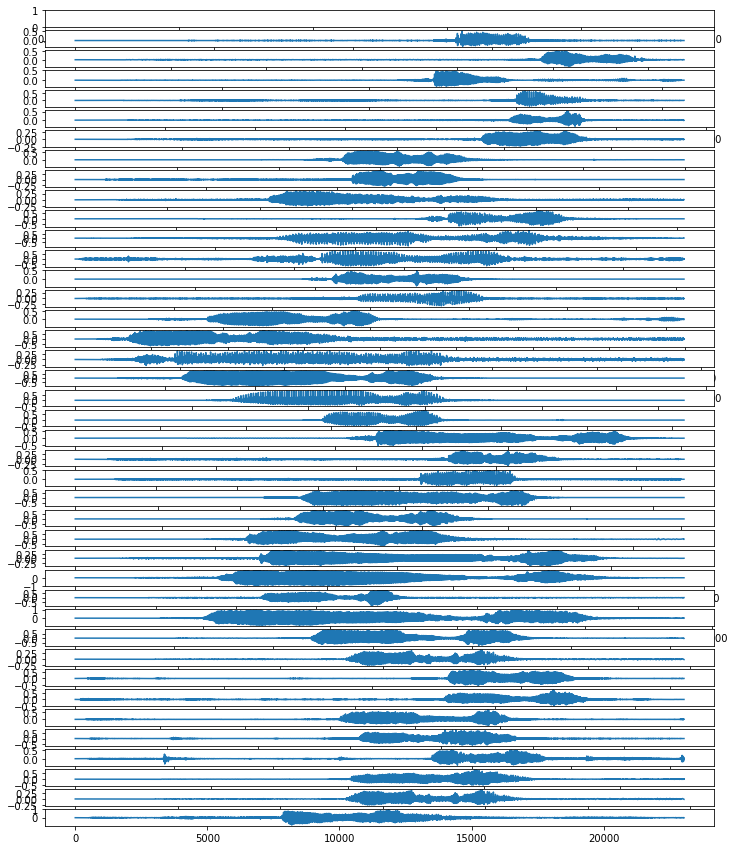

In [ ]:
folder = '/content/drive/MyDrive/ageclassification/dataasli/' #data sebelum pemotongan noise
amount = 40

fig, axes = plt.subplots(41,1, figsize=(12, 15))
for x in range(1,int(amount)+1):
  mp = folder+str(x)+'.mp3'
  signal,sr = bacadata(mp)
  axes[x].plot(signal)

*Didapatkan bahwa tidak seluruhnya x signal dipenuhi maka akan dilakukan pemotongan noise pada setiap data*

## Data suara setelah dilakukan pemotongan noise

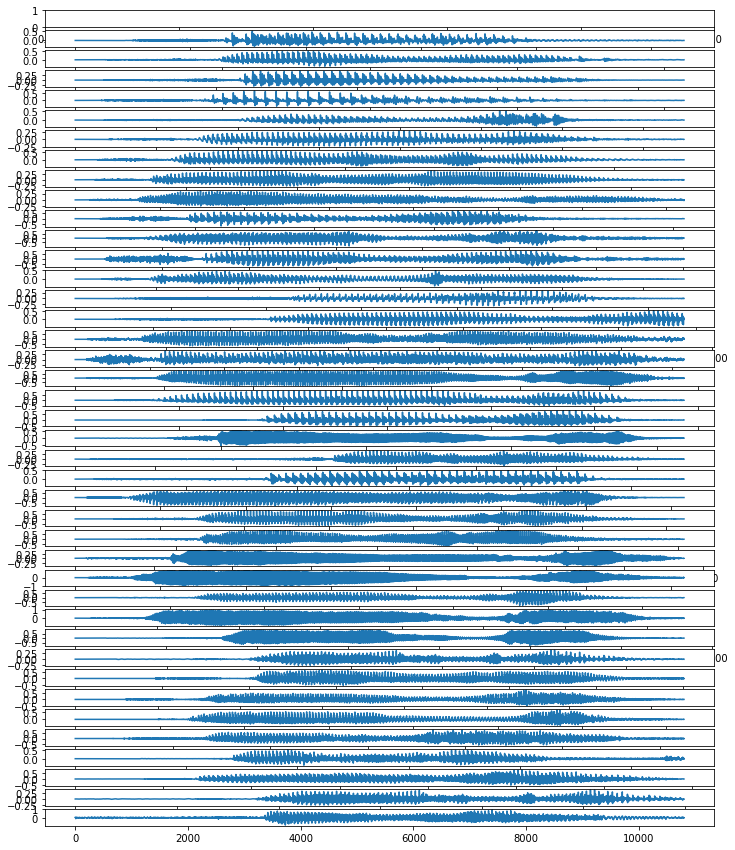

In [ ]:
folder = '/content/drive/MyDrive/ageclassification/datavalid/' #data setelah pemotongan noise
amount = 40

fig, axes = plt.subplots(41,1, figsize=(12, 15))
for x in range(1,int(amount)+1):
  mp = folder+str(x)+'.mp3'
  signal,sr = bacadata(mp)
  axes[x].plot(signal)

# Linear Predictive Coding

## Ekstraksi Ciri LPC

`Membaca data dengan frekuensi 16000Hz`

In [ ]:
def initialize(mp):
  signal,sr  = lbr.load(mp,duration=3,sr=16000)
  return signal,sr

`Membangun Fungsi LPF`

*dimana LPF akan menyaring sinyal frekuensi tinggi dan meneruskan sinyal frekuensi rendah yang diinginkan*

In [ ]:
def lowPassFilter(signal, coeff=0.97):
	return np.append(signal[0], signal[1:] - coeff * signal[:-1])

*Melakukan Teknik Filter PreEmphasis ; mendapatkan bentuk spectral frekuensi sinyal yang lebih halus*

In [ ]:
def preEmphasis(mp):
	signal , sr = initialize(mp)										#Inisialisasi sinyal awal
	preEmphasis = 0.97															#Koefisien Pre-emphasis default
	emphasizedSignal = lowPassFilter(signal)				#Pre-emphasis dibangun diatas fungsi LPF
	return emphasizedSignal, signal , sr

*OVERLAP = memberikan hasil spektrum LPC yang akan berkorelasi tiap bagiannya*

In [ ]:
#sinyal yang telah di preEmphasis diblok menjadi beberapa bagian dengan jumlah sampel N

def framing(sr,signal):	
	windowSize = 0.75																#memotong 1/4 sinyal ke dalam bentuk frame
	windowStep = 0.001															#batas ukuran kedekatan antar frame
	overlap = int(sr*windowStep)
	frameSize = int(sr*windowSize)
	numberOfframes = int(np.ceil(float(np.abs(len(signal) - frameSize)) / overlap ))	

	#membentuk frame dengan array 2-dimensi
	frames = np.ndarray((numberOfframes,frameSize))
	
	#memasukkan sampel kedalam frame
	for k in range(0,numberOfframes):
		for i in range(0,frameSize):
			if((k*overlap+i)<len(signal)):
				frames[k][i]=signal[k*overlap+i]
			else:
				frames[k][i]=0
	return frames,frameSize

`Model Window`

*WINDOW = meminimalkan diskontinyuitas pada bagian awal dan akhir sinyal*

In [ ]:
windowSize = 0.75 
frameSize = int(sr*windowSize)
window = np.hamming(frameSize)

def hamming(frames,frameSize):				#Windowing dengan Hamming
	frames*=np.hamming(frameSize)				#y[n] = s[n] * w[n] \\ (secara manual) 
	return frames

`Analisis Korelasi`

In [ ]:
def autocorrelation(hammingFrames):
	KorelasiFrames=[]
	for k in range(len(hammingFrames)):
		KorelasiFrames.append(np.correlate(hammingFrames[k],hammingFrames[k],mode='full'))	#correlateFrames adalah setiap frame setelah windowing dan autokorelasi 
	
	yolo =  KorelasiFrames[len(KorelasiFrames)/2:]
	return yolo

In [ ]:
#fungsi melihat pendekatan prediksi LPC
def autocor(signal, k):
    if k == 0:
        return np.sum(signal**2)
    else:
        return np.sum(signal[k:]*signal[:-k])

`Membangun fungsi levinson-durbin menyelesaikan sistem persamaan linier orde-n`

In [ ]:
from scipy.linalg import solve_toeplitz, toeplitz

def Levinson(w_sig,p):
    r_list = [autocor(w_sig,i) for i in range(p)]
    b_list = [autocor(w_sig,i) for i in range(1,p+1)]
    LPC = solve_toeplitz((r_list,r_list),b_list)
    return LPC

`perbandingan order analisis LPC`

In [ ]:
def Lpcspectrum(signal, window, sr, *p_):
    
    plt.figure(figsize=(10,4),dpi = 100)
    win_sig = signal*window
    for i,p in enumerate(p_):
        plt.subplot(1,len(p_),i+1)
        LPC = Levinson(win_sig, p)
        LPC = np.insert(-LPC, 0, 1)
        value = 0 
        axis = np.linspace(0,sr/2,8000)
        w2,h2 = scipy.signal.freqz([0.75], LPC, worN=8000, fs = sr)
        S_fft = np.fft.rfft(win_sig,16000)
        plt.plot(axis,30*np.log(abs(S_fft[1:])),label = 'Signal Spectrum')  
        plt.plot(axis,30*np.log(abs(h2)),label = 'LPC Spectrum')
        plt.xlim(0,sr/2)
        plt.xlabel('frequency(Hz)')
        if i== 0:
            plt.ylabel('Magnitude(dB)')
        plt.title('order <{}>'.format(p))
        plt.legend()
        plt.grid(True)
    plt.show()

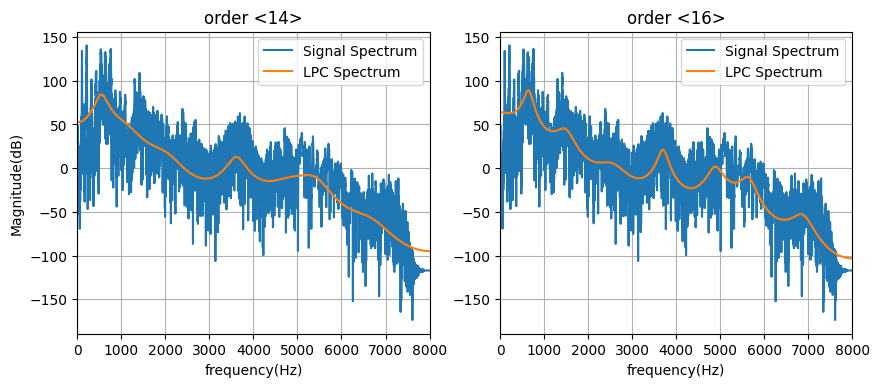

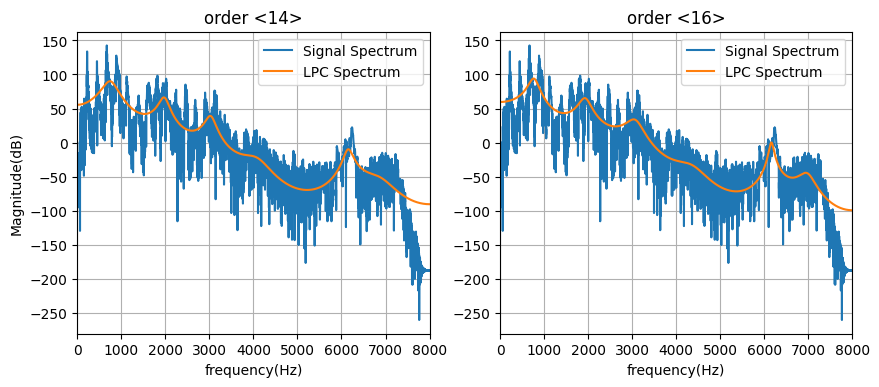

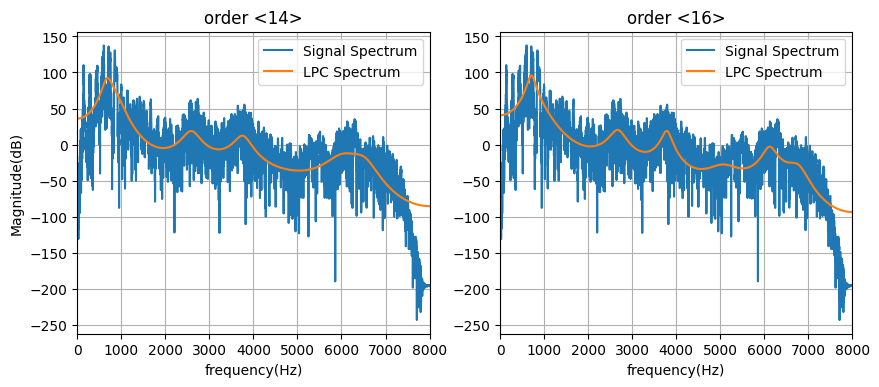

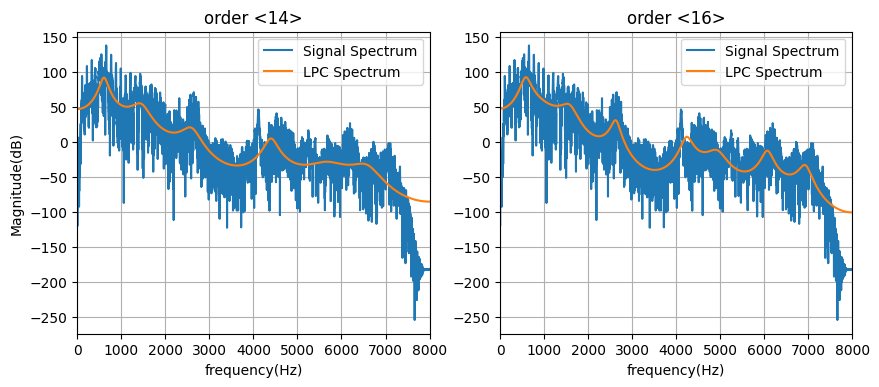

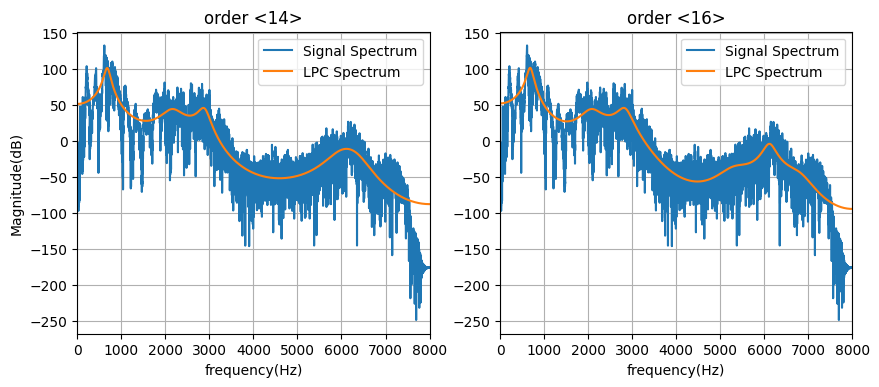

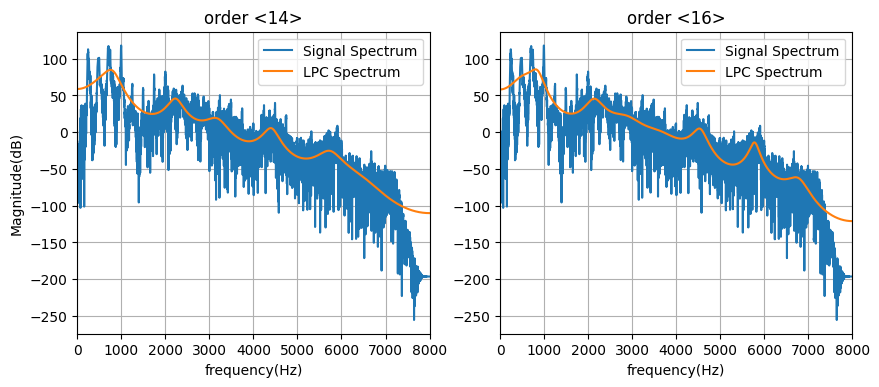

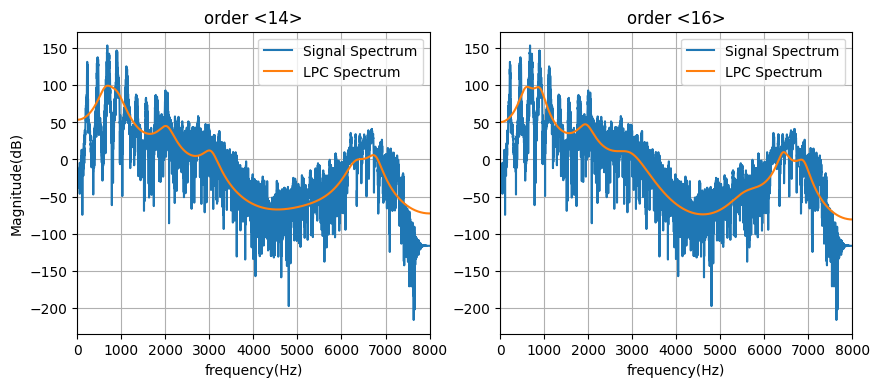

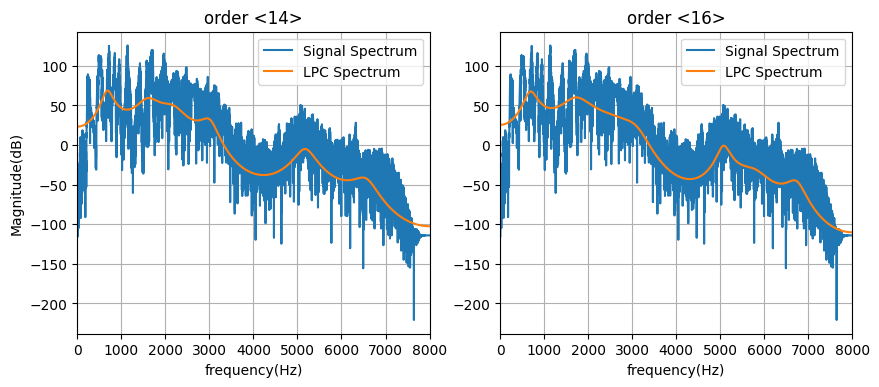

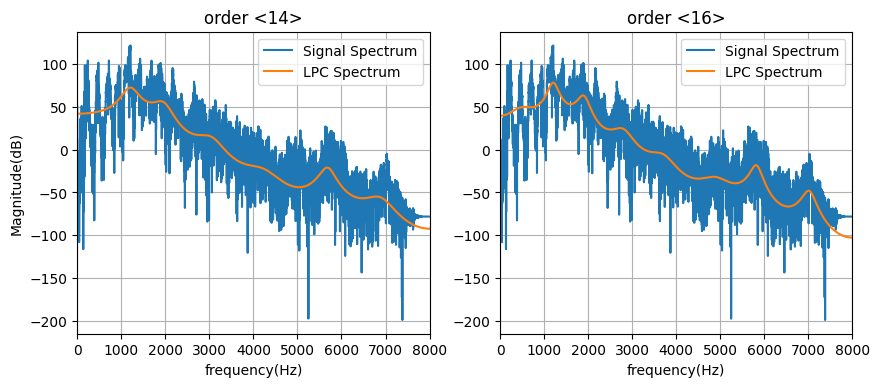

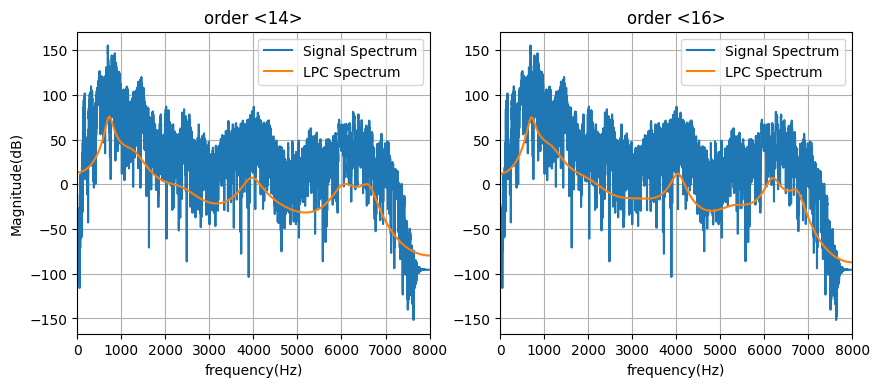

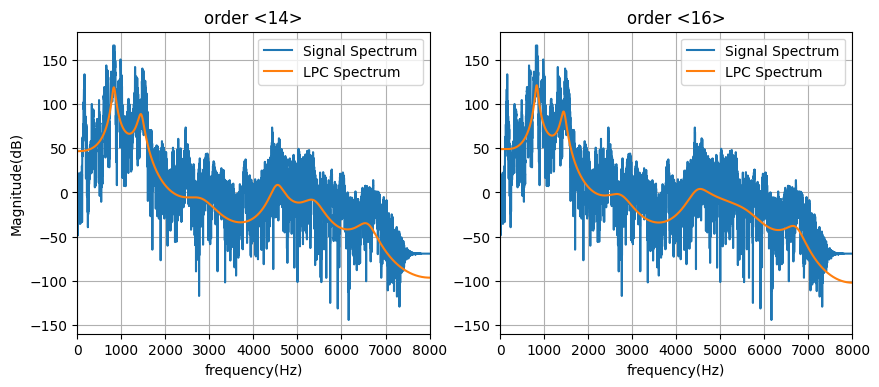

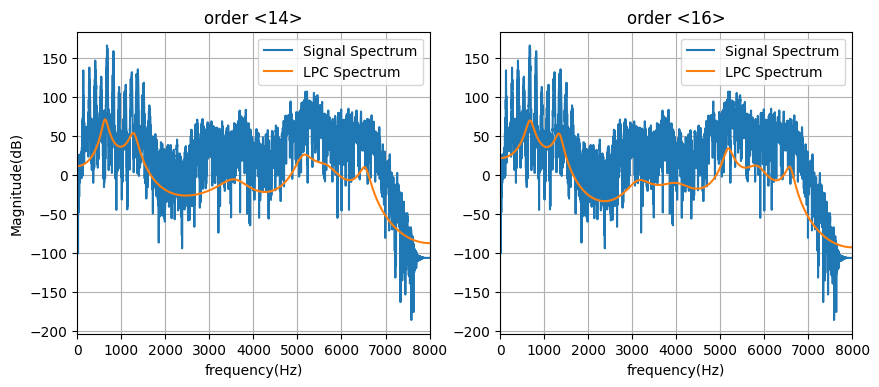

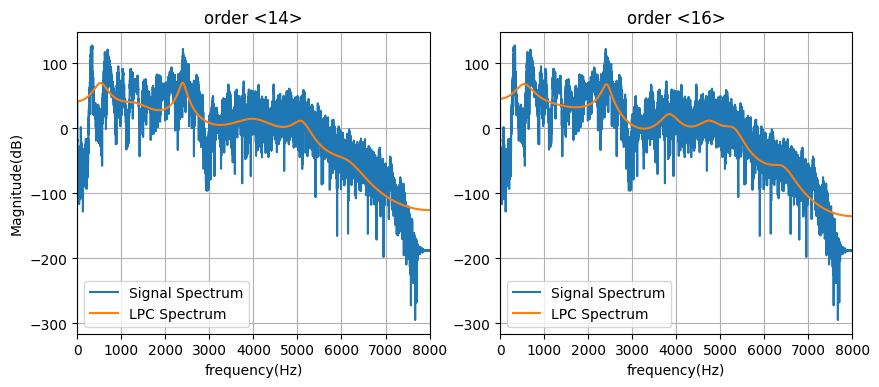

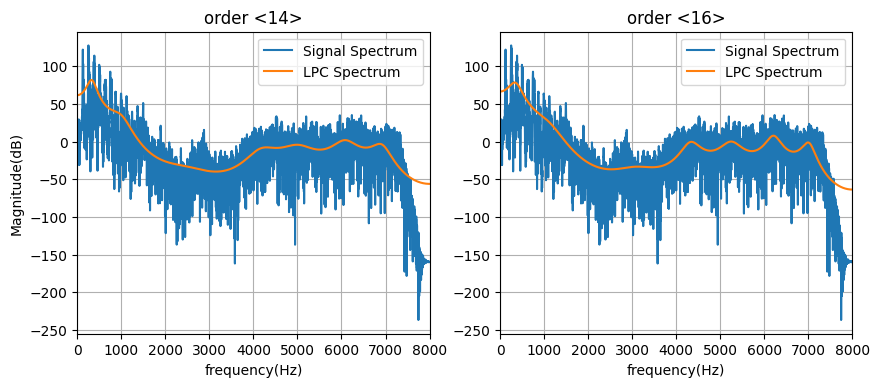

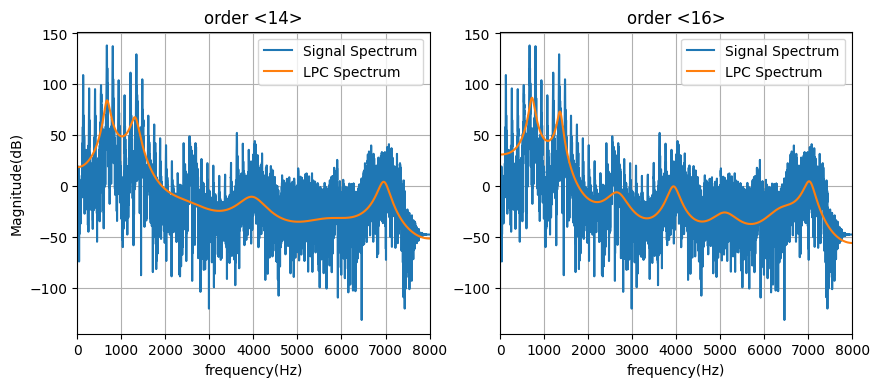

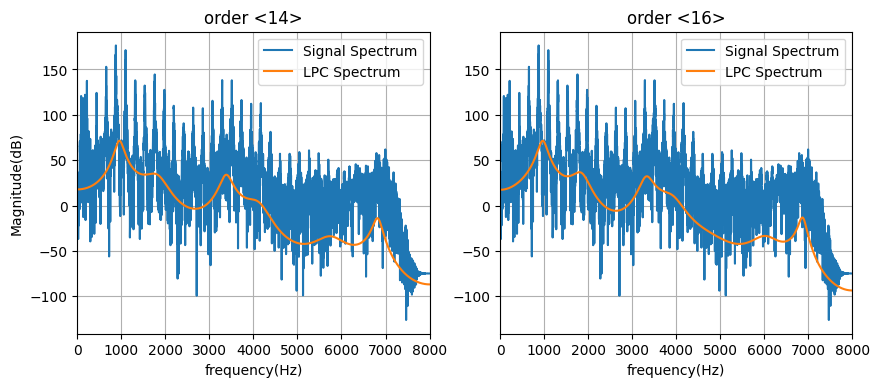

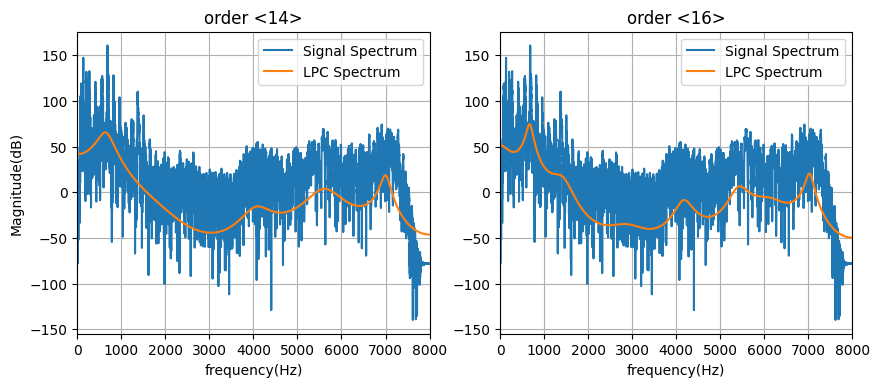

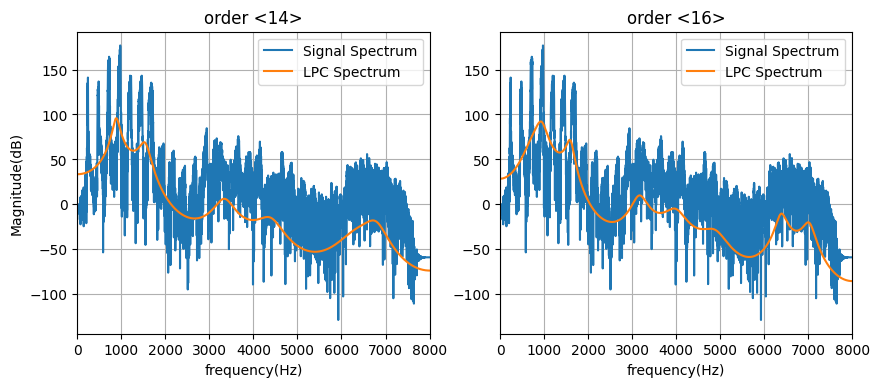

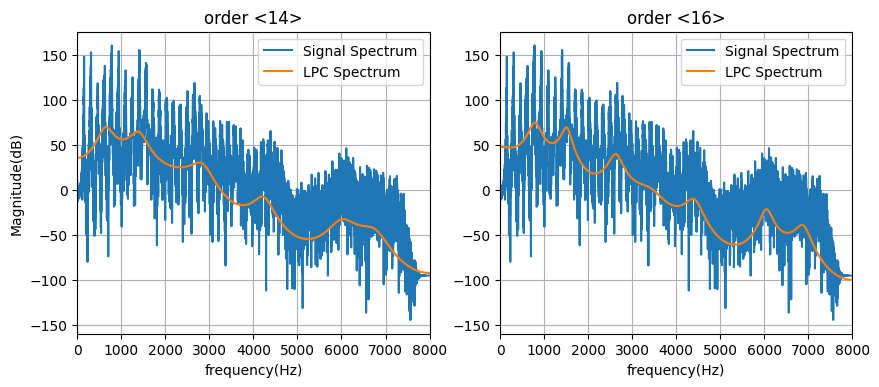

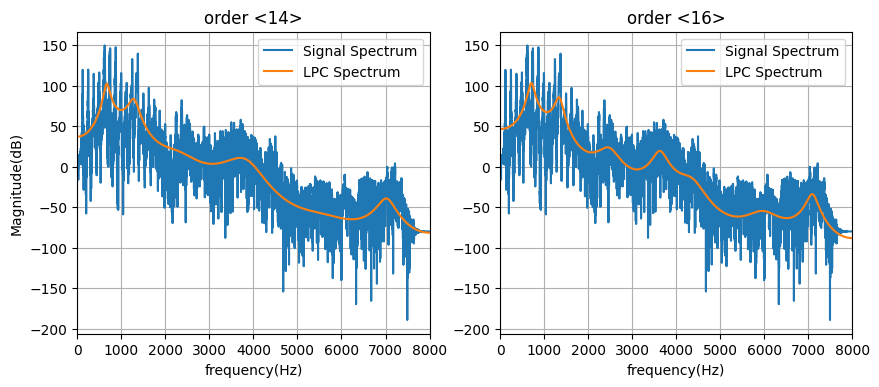

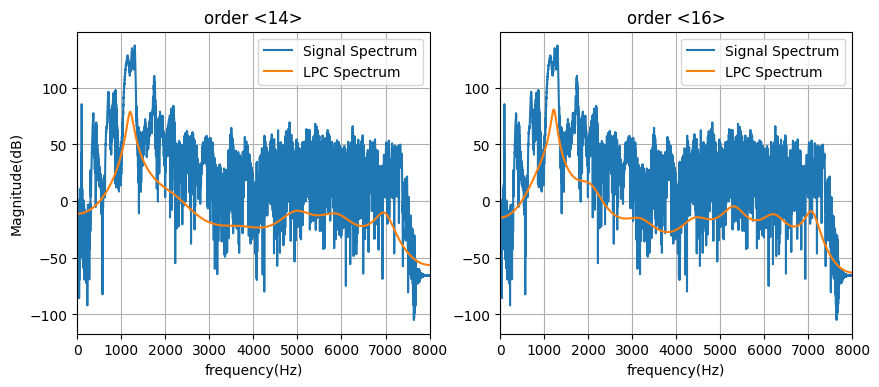

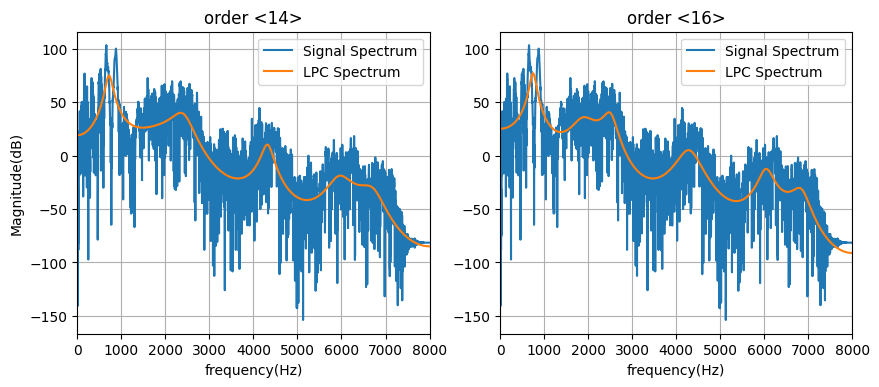

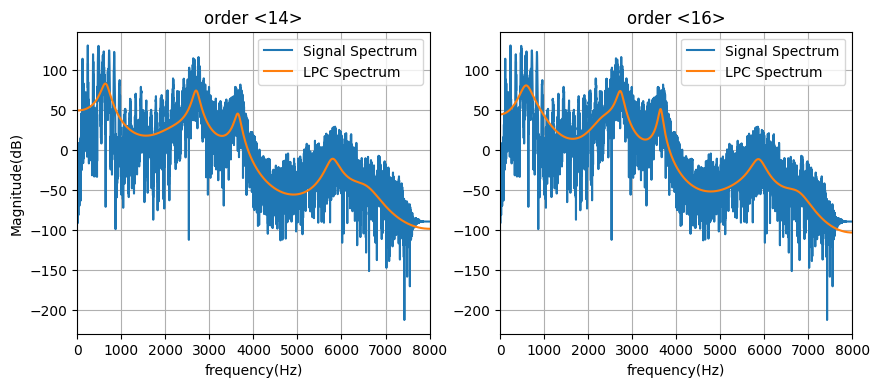

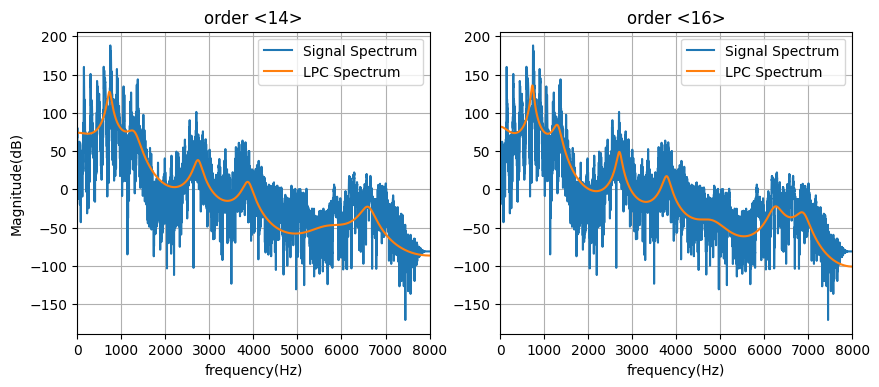

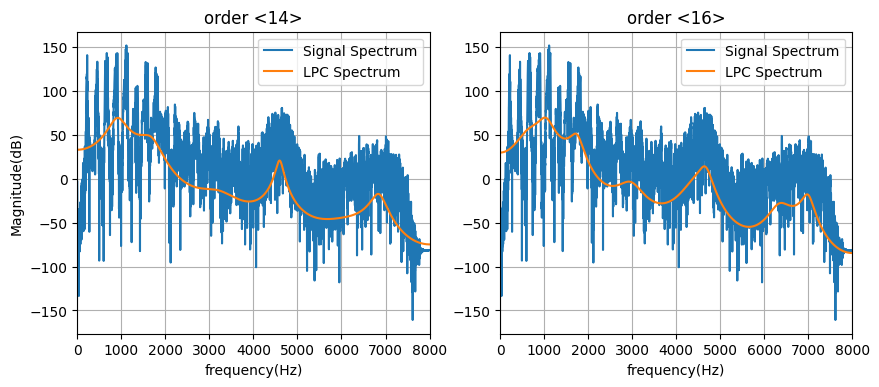

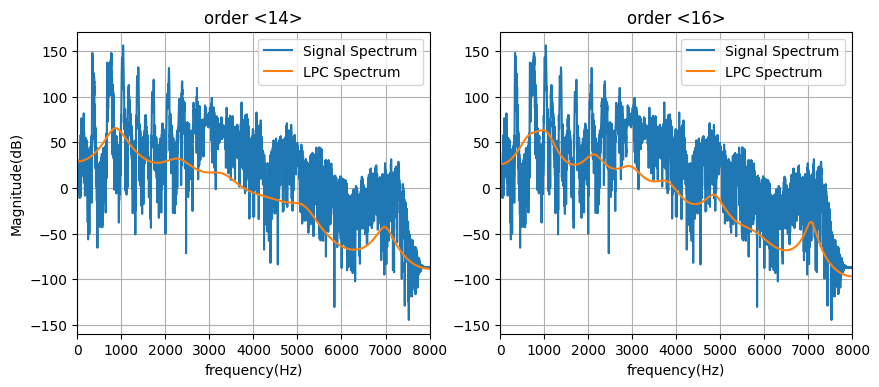

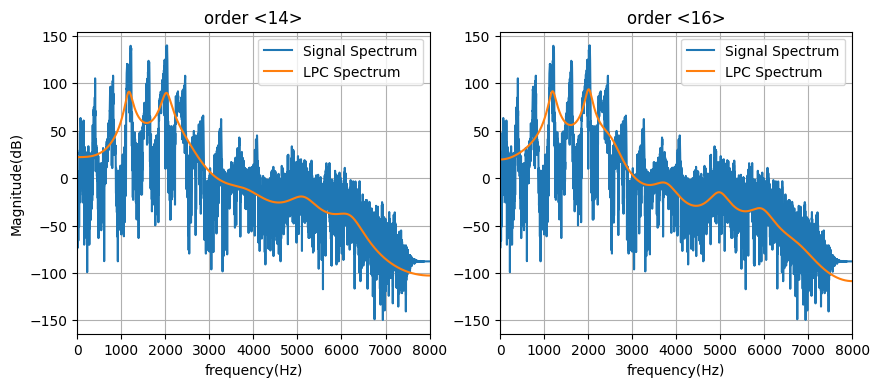

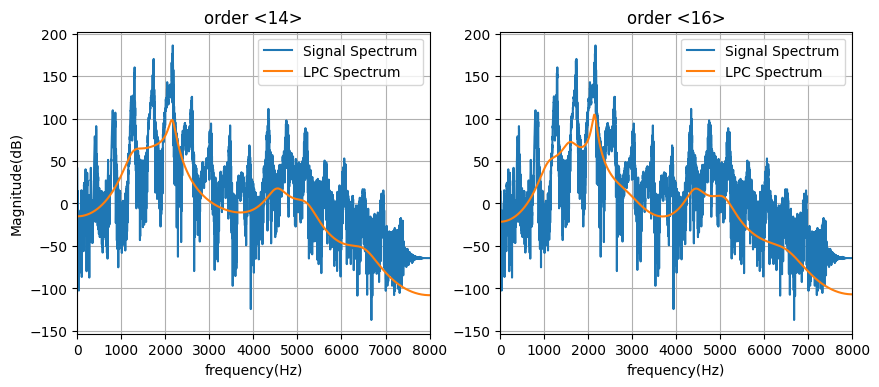

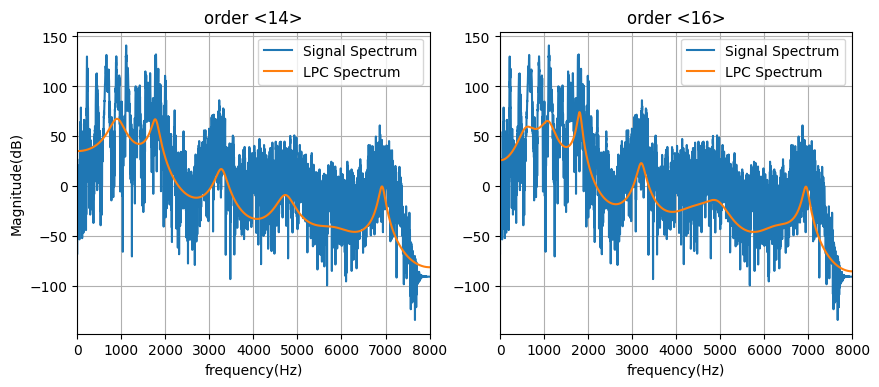

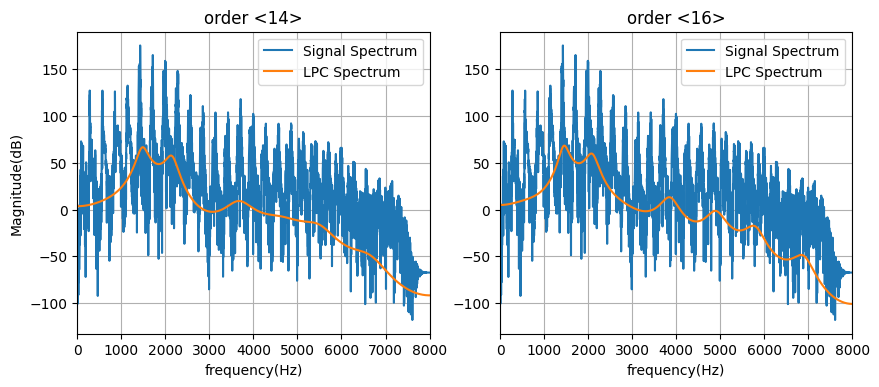

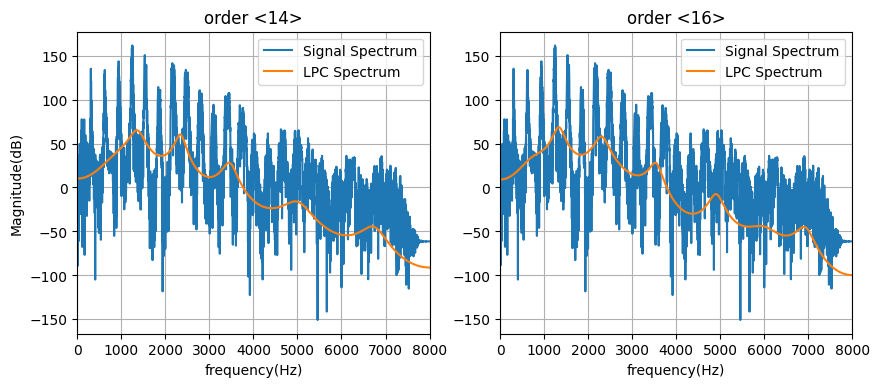

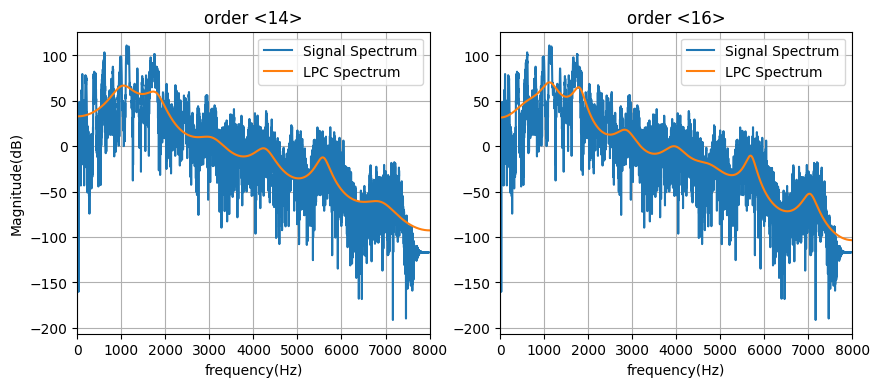

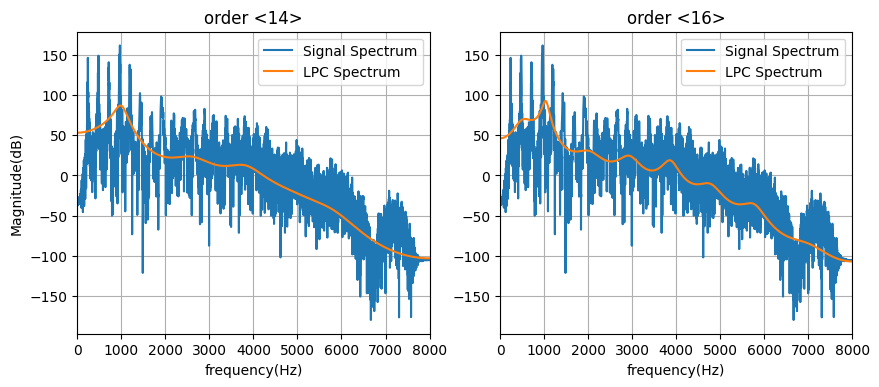

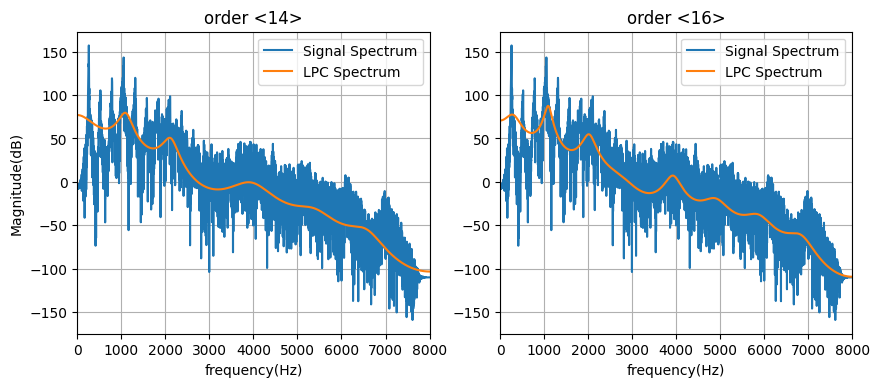

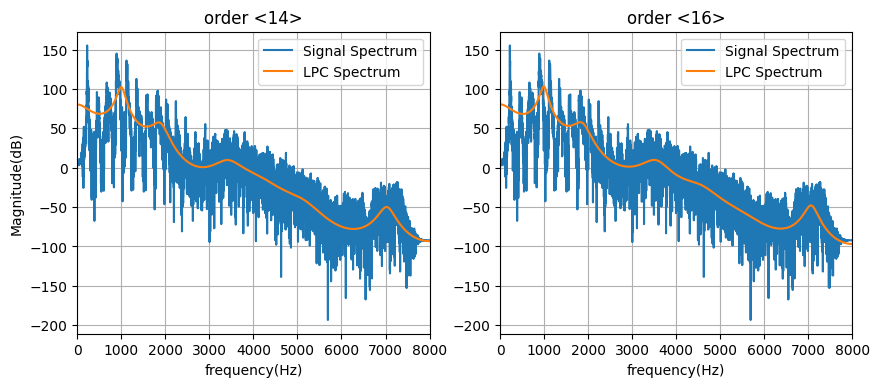

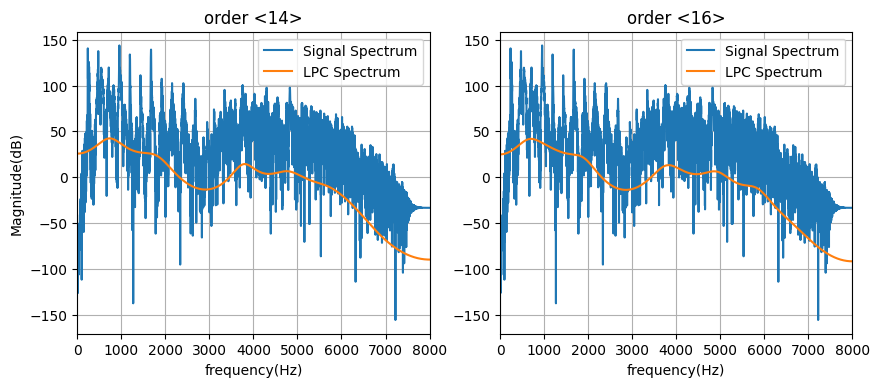

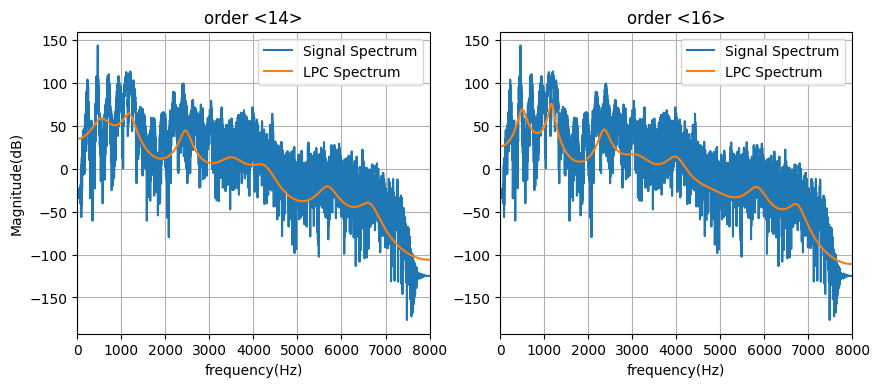

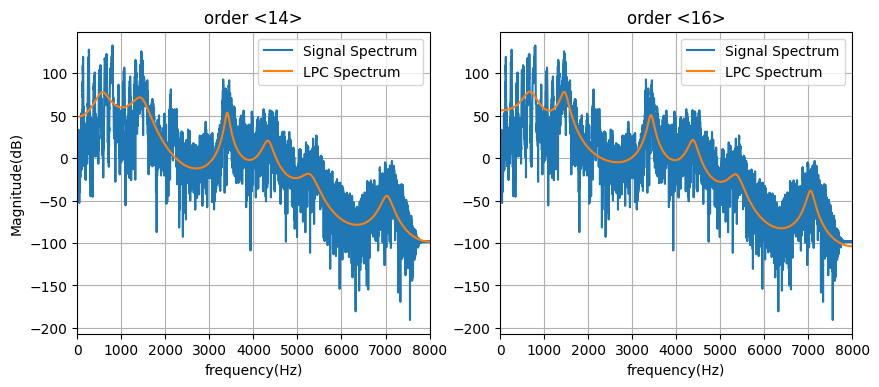

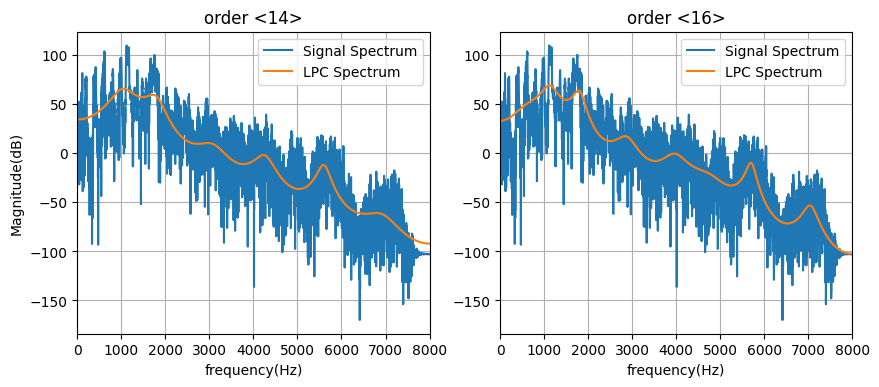

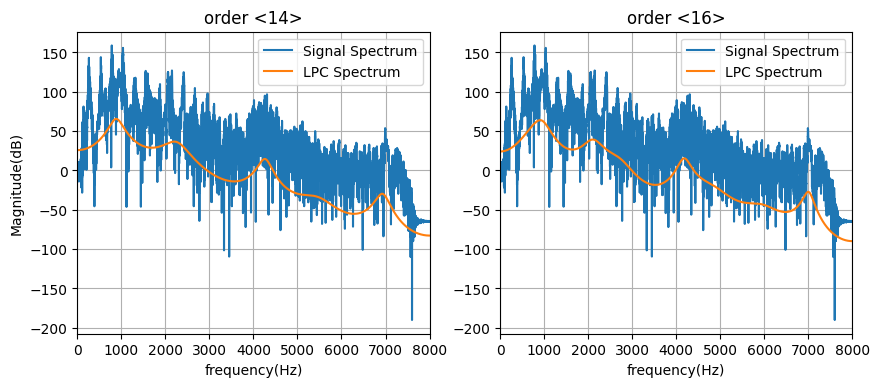

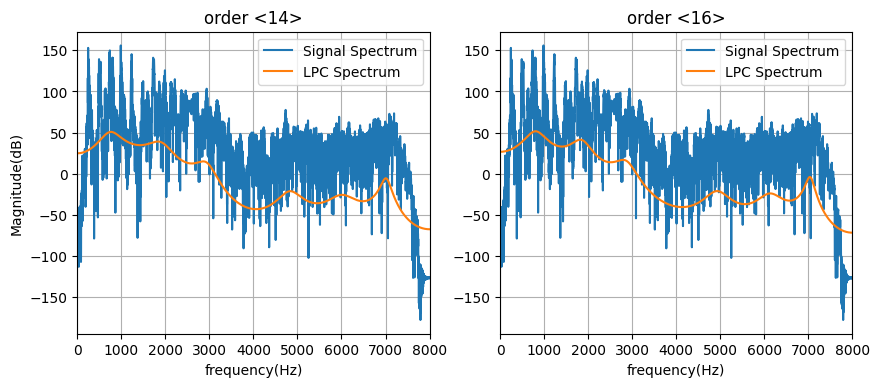

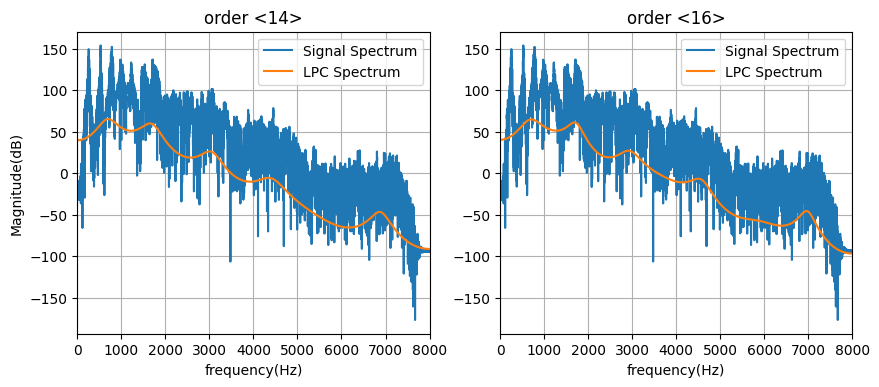

In [ ]:
folder = '/content/drive/MyDrive/ageclassification/datavalid/'
amount = 42

for x in range(1,int(amount)+1):
  mp = folder+str(x)+'.mp3'
  signal,sr = bacadata(mp)
  Lpcspectrum(signal[0:8000],1,16000,14,16)

`Analisis LPC dengan koefisien cepstral`

In [ ]:
#Proses signal dan determines koefisien lpc(dengan fungsi autocorrelation)

def LPC_autocorrelation(order=16):
	folder = '/content/drive/MyDrive/ageclassification/datavalid/'
	amount = 42
	for x in range(1,int(amount)+1):
		mp = folder+str(x)+'.mp3'
		print('jenis rekaman:',mp)
		
		#preEmhasis
		emphasizedSignal,signal,sr = preEmphasis(mp)
		length = emphasizedSignal.size

		#autocorrelation , Fast Fourier Transform (FFT)
		autocorrelation = sig.fftconvolve(emphasizedSignal, emphasizedSignal[::-1])
		#koefisien autocorrelation 
		autocorr_coefficients = autocorrelation[autocorrelation.size//2:][:(order + 1)]
		
		#metode levinson_durbin dengan rumus toeplitz
		lpc_coefficients_levinson = levinson_durbin(autocorr_coefficients,16)
		print('koefisien korelasi dengan metode levinson:',lpc_coefficients_levinson.numerator)
		
		#Matriks Toeplitz
		R = linalg.toeplitz(autocorr_coefficients[:order])
		lpc_coefficients = np.dot(linalg.inv(R), autocorr_coefficients[1:order+1])

		#Ekstrak fitur LPC
		lpc_fitur=[]
		for i in lpc_coefficients:
			lpc_fitur.append(i)
		print('lpc fitur;',lpc_fitur)

In [ ]:
def main():	
	LPC_autocorrelation()

#running Ekstraksi LPC
main()

jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/1.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.0476536319058756, 1.1190804165188621, -1.2792307085553345, 1.2423156215622309, -0.9752326549885665, 0.9983386090151513, -0.7087526736604945, 0.7304666847776864, -0.7750072281371447, 0.911824472168489, -0.7212116531951762, 0.7771138739577869, -0.70961903043587, 0.5972825863035871, -0.21279802528686562, 0.23542361499223663]
lpc fitur; [1.0476537, -1.1190798, 1.2792299, -1.2423135, 0.97523105, -0.9983374, 0.7087515, -0.73046523, 0.7750057, -0.9118228, 0.72121, -0.777113, 0.70961726, -0.59728146, 0.21279737, -0.23542316]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/2.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.4928705917130791, 1.2037603141279332, -0.36048165095861295, 0.356499805554091, -0.8315657116641689, 1.3516988414936335, -1.1361074366712491, 0.7579440527578993, -0.35146944925213847, 0.3959592971083423, -0.471502812352441, 0.8219281008374162, -0.6841034421795257, 0.5669639457431028, -0.3338344174804443, 0.19120994716171114]
lpc fitur; [1.492872, -1.2037625, 0.36048746, -0.3565066, 0.83157015, -1.3517041, 1.1361135, -0.7579551, 0.35147667, -0.39596736, 0.4715066, -0.82193065, 0.68410885, -0.56696886, 0.33383882, -0.19121224]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/3.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.7257664541450634, 0.604283923942833, -0.6417505757631758, 0.6789657908836326, -0.9430033498443782, 1.0695697663241788, -0.6722128878335751, 0.8152626454535573, -0.5193988264228449, 0.8041955769650827, -0.548840935072353, 0.3675315791505591, -0.4002504810317159, 0.44717181693853103, -0.18614785123260083, 0.25797580524760466]
lpc fitur; [0.7257669, -0.6042845, 0.64175105, -0.6789659, 0.94300365, -1.0695703, 0.6722131, -0.8152635, 0.5193987, -0.8041949, 0.54884124, -0.3675319, 0.4002508, -0.4471718, 0.18614769, -0.25797576]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/4.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.0554641807844445, 0.6834936774846241, -0.7864047732916397, 1.0335254615751366, -0.7008173620663878, 0.7564365808235126, -1.0110548002022244, 0.9987801411323115, -0.5065206709486512, 0.5951347805321291, -0.7704706267461968, 0.5841176878714173, -0.38792784957512905, 0.6440779598522007, -0.3682675474456923, 0.11743564100506262]
lpc fitur; [1.0554632, -0.6834922, 0.78640294, -1.0335237, 0.70081425, -0.7564329, 1.0110519, -0.99877644, 0.50651765, -0.59513235, 0.77046895, -0.58411527, 0.3879267, -0.64407724, 0.36826694, -0.11743519]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/5.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.111051939598067, 0.6390782199398269, -0.1555164554430327, 0.7978646252451636, -1.3549986622753265, 0.9465836968008177, -0.3116582526527244, 0.46579483085716555, -0.6524227543870142, 0.650439828185811, -0.22835939832079286, 0.31429801138542157, -0.23278845349052946, 0.3279945767018777, -0.17522637725326187, 0.11168429161939201]
lpc fitur; [1.111053, -0.6390797, 0.15551639, -0.79786396, 1.3549979, -0.94658375, 0.3116579, -0.46579456, 0.6524229, -0.6504402, 0.22836041, -0.3142979, 0.23278856, -0.3279947, 0.17522728, -0.111684754]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/6.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.5666514644490097, 1.9571596545920378, -2.0065057230900956, 2.080681725302517, -2.0335697810228495, 1.993013216566415, -1.8682827278039167, 1.773724563749481, -1.3981761709883866, 1.318787626046089, -1.141647690137634, 1.226380268079632, -1.0001676692471015, 0.6926999960639559, -0.33842778143457686, 0.10832507757302418]
lpc fitur; [1.5666509, -1.9571571, 2.0065007, -2.080678, 2.0335636, -1.9930067, 1.8682795, -1.7737198, 1.3981705, -1.3187809, 1.1416407, -1.2263775, 1.0001678, -0.69269705, 0.3384273, -0.10832524]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/7.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.999716527745142, -0.24745712110085122, 0.6924211493578736, 0.617512244514554, -1.4970132993604057, 0.796401733950056, 0.3028817444231415, -0.0012899792141699829, -0.6913978756327928, 0.7636855433409291, -0.15037411379160165, 0.05960701948252313, -0.1700691544898812, 0.2582150804418268, -0.2267226606639926, 0.12917857344236267]
lpc fitur; [0.99971616, 0.2474584, -0.6924219, -0.61751366, 1.4970123, -0.7964015, -0.3028854, 0.0012903214, 0.6913967, -0.76368594, 0.1503725, -0.059605062, 0.17006731, -0.25821495, 0.22672278, -0.12917826]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/8.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.3225267016075115, 1.3992547769583654, -1.0664686962188947, 1.6292249204973615, -1.6126791433116523, 1.4823633011137376, -1.0607134602484158, 1.3932869807418462, -1.3345889743544261, 1.1716934909126662, -0.6926661907429706, 0.7602372470572869, -0.5700300411153738, 0.5117700752351195, -0.20482811483018196, 0.15557496533315832]
lpc fitur; [1.3225255, -1.3992522, 1.066466, -1.6292251, 1.6126729, -1.4823608, 1.060708, -1.3932817, 1.334584, -1.171694, 0.69266176, -0.76023686, 0.57002854, -0.5117687, 0.20482707, -0.15557425]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/9.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.4866757059374989, 1.5677435725183575, -1.2397221091427313, 1.4695361639120346, -1.3799522478818929, 1.4421345688218943, -1.1161694559868418, 1.132494267967651, -1.0784067010655123, 1.2398826580170113, -1.1689354291008938, 1.195060233430755, -1.0357977739328823, 0.8821626197117397, -0.5645951500516946, 0.20326971096365218]
lpc fitur; [1.4866791, -1.5677502, 1.2397285, -1.4695468, 1.3799605, -1.4421451, 1.1161784, -1.1325049, 1.0784172, -1.2398903, 1.1689407, -1.1950636, 1.035802, -0.8821672, 0.564598, -0.2032707]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/10.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.37750156302329985, 0.3824704896553488, -0.5394580536535617, 0.6901797777056009, -0.6037266542020128, 1.083704421271409, -0.5901166070292561, 0.6441939995232902, -0.49716082264927464, 0.8389777041727919, -0.44529126693112264, 0.4821817773038202, -0.2769041132084201, 0.3661951730310141, -0.15844323581236264, 0.35424926006595137]
lpc fitur; [0.37750158, -0.38247076, 0.5394581, -0.6901797, 0.6037266, -1.0837045, 0.5901167, -0.64419436, 0.49716127, -0.8389779, 0.44529146, -0.4821819, 0.27690423, -0.36619526, 0.15844333, -0.35424936]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/11.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.3214823485841105, 1.28211637273614, -1.6088410487276201, 1.981142602579999, -1.637749639132971, 1.8321984142397478, -1.797899299334107, 1.868810322981518, -1.619381289009683, 1.4900480103291092, -1.2896797366578683, 1.2308565295723843, -0.7642374061085241, 0.6329894385801147, -0.3685923016608244, 0.22124332224559304]
lpc fitur; [1.3214769, -1.2821045, 1.6088238, -1.9811172, 1.6377144, -1.8321648, 1.7978516, -1.868782, 1.6193466, -1.4900055, 1.289648, -1.2308235, 0.76420975, -0.6329746, 0.36858082, -0.22123909]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/12.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.2188320903222496, 0.6516025323472954, -1.056708008281903, 0.9290686698770393, -1.0337349435533, 1.2737349783880996, -0.7570953968556007, 1.4740487664932347, -0.9188491799868572, 0.9183281283103927, -0.8142756536775473, 0.5889685940295475, -0.5328577516147222, 0.5552661766932002, 0.06667408484277931, 0.4064206015073104]
lpc fitur; [0.21883205, -0.651602, 1.0567081, -0.92906827, 1.0337346, -1.2737354, 0.75709486, -1.4740485, 0.9188479, -0.9183279, 0.81427574, -0.5889683, 0.5328578, -0.55526567, -0.06667463, -0.4064204]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/13.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.5071863091523678, 2.3940489453443976, -2.8809354774213967, 3.455895874420944, -3.412347313005937, 3.352915978340312, -3.141374066213746, 2.8979043401536266, -2.5054588792441015, 2.3714260357429144, -1.8392326928321299, 1.4524748862224852, -0.9646554952188025, 0.6662250774342429, -0.2395931168010805, 0.1377278925290735]
lpc fitur; [1.507185, -2.3940434, 2.8809333, -3.4558973, 3.412345, -3.3529053, 3.1413784, -2.8979092, 2.5054321, -2.3714228, 1.8392372, -1.4524746, 0.96465683, -0.66622686, 0.23959327, -0.13772802]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/14.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, 0.035602690477005, -0.18211239486439595, -0.7137947029014691, 0.040214918068485254, -0.08910924991431292, 0.4666381606683672, -0.1535575686188873, 0.23476591364748464, -0.14305034952351103, 0.22175407510587386, -0.25450525177187805, 0.07471904745959412, -0.16060315010933957, 0.26565525638810983, -0.05503958586834298, 0.1339928854557934]
lpc fitur; [-0.03560271, 0.18211234, 0.7137947, -0.04021482, 0.08910921, -0.46663827, 0.15355757, -0.23476598, 0.14305034, -0.22175404, 0.25450528, -0.07471903, 0.16060318, -0.26565528, 0.055039592, -0.13399291]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/15.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.6081134534624317, 0.04349909441455178, 0.0012897965747692176, 0.24716786731061535, -0.35216027157900387, 0.6725701222604346, -0.24991607936604615, 0.21185739319862257, -0.1393004662172755, 0.45201796516850445, -0.36670365204705185, 0.1119371412846078, -0.03672059508772053, 0.2908648515983667, -0.023829269956785804, 0.16677915196957782]
lpc fitur; [0.60811365, -0.04349874, -0.0012900829, -0.24716787, 0.35216027, -0.67257005, 0.24991566, -0.21185732, 0.1393004, -0.452018, 0.36670357, -0.11193699, 0.0367205, -0.29086468, 0.023829222, -0.16677904]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/16.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.8367695736379532, 1.1093771124226335, -0.5775384166626092, 0.713678961943753, -0.5105743775043297, 1.0921629637658754, -0.6878779094855613, 1.0815774530510116, -0.6659392668523235, 0.9196030567188016, -0.48587653304720824, 0.7052521108119529, -0.3140791619129337, 0.5011031916249974, -0.2079201064867325, 0.2695231249637543]
lpc fitur; [0.83676994, -1.1093776, 0.5775385, -0.7136791, 0.51057494, -1.0921634, 0.6878784, -1.081578, 0.6659398, -0.91960305, 0.48587656, -0.7052525, 0.31407973, -0.50110346, 0.20792031, -0.26952326]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/17.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, 0.09426709256882597, -0.11291939024841766, -0.3932134887854772, 0.22019923907892186, 0.00861723745633975, 0.38024374555908014, -0.10335875943353592, 0.14119989359467608, -0.20954576722223486, 0.4301893843082679, -0.0043241522690606275, 0.11708512834314118, -0.09510820756119297, 0.2094403980306382, 0.09039518830203272, 0.23779618274863593]
lpc fitur; [-0.09426711, 0.112919345, 0.39321357, -0.2201993, -0.008617222, -0.38024378, 0.10335877, -0.14119993, 0.20954584, -0.43018937, 0.004324138, -0.117085144, 0.0951082, -0.20944043, -0.09039517, -0.23779619]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/18.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.9266057590332644, 0.44532266481794697, -0.2734011959006252, 0.35873668050387636, -0.24976403030138158, 0.8699318780792398, -0.6706237099217328, 0.6340332027880878, -0.5183568732707227, 0.34445420232961305, -0.1852891286023588, 0.41376827210233763, -0.19225019123159692, 0.3576653063030475, -0.38750862522990165, 0.17172457180017256]
lpc fitur; [0.92660534, -0.4453225, 0.2734009, -0.3587364, 0.2497639, -0.8699318, 0.6706238, -0.6340327, 0.51835656, -0.3444537, 0.18528867, -0.4137683, 0.19225025, -0.35766494, 0.38750792, -0.17172396]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/19.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.3237023087145716, 1.202582429438189, -0.6402091881150539, 0.6573754085238237, -0.8034069949375757, 1.2099433942742734, -1.1336882605777383, 1.038575874211126, -0.5543941554796965, 0.4561043827716051, -0.5381177895820588, 0.782922673438355, -0.626538419137654, 0.46148712551417, -0.10333257906538647, 0.07884806434387522]
lpc fitur; [1.3237023, -1.2025818, 0.6402091, -0.657375, 0.80340624, -1.2099435, 1.1336873, -1.0385742, 0.55439305, -0.45610428, 0.5381174, -0.7829232, 0.62653863, -0.46148777, 0.103333, -0.078847885]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/20.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.5963554462390726, 1.47236917367278, -0.7594383205043871, 0.15505435319102223, 0.058349724827101546, 0.5148747547350447, -0.9014996047248461, 1.0193912956391242, -0.633667572570257, 0.47235830260915856, -0.37628051628986237, 0.5605324824467756, -0.663466994954045, 0.6401529581978243, -0.26135093945015353, 0.17158486332416553]
lpc fitur; [1.596354, -1.4723692, 0.75943995, -0.15505338, -0.0583508, -0.51487905, 0.90150595, -1.0193968, 0.63366795, -0.47235823, 0.3762787, -0.56053233, 0.6634673, -0.64015484, 0.26135278, -0.17158526]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/21.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.23850280609071228, 0.5483245702358276, -0.011563119760883943, 0.7999811724584218, 0.003070844734420007, 0.7784559323805551, 0.24660495284517567, 0.6391690653274382, -0.020730293514133073, 0.6440082534825643, 0.15777513051098824, 0.42591581037963294, -0.07176190365797842, 0.29945022604553806, -0.017555517466304845, 0.15259666693605203]
lpc fitur; [0.23850298, -0.5483245, 0.0115632415, -0.7999815, -0.0030705929, -0.77845585, -0.24660468, -0.6391691, 0.020730615, -0.6440084, -0.1577748, -0.42591596, 0.071762085, -0.29945028, 0.017555714, -0.15259671]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/22.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.231470442958574, 1.3760328318579778, -0.9913721618430101, 1.2141757189698552, -1.104746487849067, 1.3606265033596154, -1.4821156784475407, 1.4335480799934948, -0.9294921384155628, 0.9109294897928784, -0.8181650409266009, 0.9750797115080004, -0.6386156401441166, 0.6722235802569569, -0.2976249511193161, 0.22289021702596643]
lpc fitur; [1.2314694, -1.3760313, 0.9913699, -1.2141715, 1.104742, -1.3606236, 1.4821129, -1.4335456, 0.9294877, -0.9109248, 0.81816226, -0.97507745, 0.63861406, -0.67222303, 0.29762566, -0.22289032]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/23.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.3423056990064997, 1.5468908264174284, -1.048961342598888, 1.1949425040474102, -1.7336556075051814, 1.884493217561989, -1.4459311029430566, 1.0155984985092372, -0.9126411078780343, 1.3651369123099475, -1.1600338969045354, 0.8604020276549127, -0.4953292247842667, 0.6470563187833315, -0.47410732148450824, 0.2885439109005691]
lpc fitur; [1.3422971, -1.5468731, 1.048934, -1.1949043, 1.7336159, -1.8844547, 1.4458828, -1.0155563, 0.91259766, -1.3651085, 1.1600037, -0.86037636, 0.49531364, -0.6470442, 0.4741001, -0.28853893]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/24.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.6117288786437145, 1.4434257215988708, -0.8632791729796245, 0.5312308190831908, -0.8703394003980713, 1.6025605307987183, -1.6514525215461158, 1.4368016037864568, -0.8856966374894166, 0.8095730623560582, -0.8824495306963911, 0.8508477186634757, -0.7587647871394406, 0.791274727594286, -0.4832114642294256, 0.22697422745046833]
lpc fitur; [1.6117349, -1.4434414, 0.8632927, -0.5312557, 0.8703575, -1.6025782, 1.6514874, -1.4368248, 0.8857155, -0.809597, 0.8824749, -0.85087585, 0.75878525, -0.79128647, 0.4832182, -0.22697687]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/25.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.9302460152912002, 0.6875758566581658, -0.4142588684118082, 0.47962828767850585, -0.11570327316586582, 0.5045435288425428, -0.7031174708304182, 0.9627865174906064, -0.5565019685172684, 0.39307410566170664, -0.16752930403393906, 0.37187243403343295, -0.2629689817399315, 0.3610693557822494, -0.3017455216977033, 0.22120571064491648]
lpc fitur; [0.93024635, -0.6875758, 0.4142586, -0.47962806, 0.11570299, -0.5045434, 0.7031175, -0.9627863, 0.55650175, -0.39307368, 0.1675291, -0.37187207, 0.26296875, -0.36106926, 0.3017453, -0.22120547]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/26.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.20823574398719, 1.4168315691111315, -0.9626283589672905, 0.845763770586724, -0.3750650964000384, 0.47832655391826306, -0.321505422882408, 0.6832949600324225, -0.6475748797093233, 0.8988436781312027, -0.6627103357695012, 0.7039931923595384, -0.5000110341764747, 0.4596450087018896, -0.2313525105471943, 0.10640871496010905]
lpc fitur; [1.2082365, -1.4168327, 0.96263075, -0.8457674, 0.37506908, -0.47832972, 0.32150847, -0.6832971, 0.6475765, -0.8988458, 0.66271234, -0.7039957, 0.5000138, -0.4596474, 0.2313537, -0.10640934]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/27.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.507288773177212, 2.319908331497554, -2.350073319023584, 3.112222540477504, -2.7286126717758643, 3.1309971534515153, -2.7018852690979007, 2.9584932693732036, -2.1817324996690206, 2.091996752761485, -1.3068001110667353, 1.0990505681380633, -0.5715754194927223, 0.5522119530534829, -0.2852941476641714, 0.1375573657407829]
lpc fitur; [1.5072722, -2.3198786, 2.3500156, -3.1121502, 2.7284966, -3.1308823, 2.701767, -2.9583778, 2.181614, -2.0918808, 1.306694, -1.0989723, 0.5715332, -0.55218506, 0.28528118, -0.13755226]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/28.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.080908448642985, 1.917849430179144, -1.6314319049696848, 2.7793628476368055, -1.991683247656095, 2.8516691060199886, -2.0994398622809163, 2.8597052990747285, -1.8371932264850641, 2.2568986591503837, -1.4097130165047327, 1.6276678776315485, -0.8807378594085777, 0.9083929076931386, -0.4830597499476238, 0.33223940470450997]
lpc fitur; [1.0809064, -1.9178572, 1.6314545, -2.7793903, 1.9917374, -2.851738, 2.0995216, -2.8597794, 1.8373299, -2.2569656, 1.4098091, -1.6277695, 0.8807926, -0.90844536, 0.48308945, -0.33225346]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/29.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.6807042369237862, 0.4512551754178826, -0.3112746994388738, 0.5245851835697631, -0.2548276205805069, 0.6561778811489711, -0.630215940321588, 0.8330243181219794, -0.5616612343924975, 0.4462413771314958, -0.2599587270411944, 0.5403608989061945, -0.15852528692763965, 0.25644820755755093, -0.31534268706808743, 0.2111773498740451]
lpc fitur; [0.6807045, -0.45125547, 0.31127504, -0.5245856, 0.2548279, -0.6561782, 0.6302161, -0.83302474, 0.56166154, -0.4462415, 0.25995877, -0.5403609, 0.15852565, -0.25644842, 0.31534275, -0.21117747]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/30.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.6931390474098712, 1.1856476975418246, -0.7078742868686839, 1.421959304163702, -0.61715611393224, 1.3102733515402731, -0.67910119748674, 1.2001193643628403, -0.633612192043399, 1.0796325440008545, -0.49608814428048853, 0.7124084787446074, -0.4055591600763211, 0.45746077165465104, -0.19583411602863185, 0.16244315158137643]
lpc fitur; [0.6931398, -1.1856482, 0.707876, -1.4219598, 0.6171584, -1.3102742, 0.6791024, -1.20012, 0.6336138, -1.0796328, 0.49608922, -0.712408, 0.40556014, -0.4574605, 0.19583398, -0.16244304]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/31.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.9631290408415322, 1.2384311529411636, -0.6445500178146502, 0.9094100321277717, -0.6087002679036938, 0.9736563732405983, -0.6078360672227562, 0.9039822589543987, -0.55126773459105, 0.7336234041124328, -0.355963144954371, 0.5527979642387352, -0.5338139873104935, 0.5402546888199244, -0.27763521633072935, 0.1779294331912121]
lpc fitur; [0.96312946, -1.2384329, 0.64455235, -0.90941143, 0.6087026, -0.97365856, 0.6078385, -0.9039857, 0.5512703, -0.73362625, 0.35596535, -0.5527994, 0.53381485, -0.5402561, 0.27763614, -0.17792977]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/32.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.2974843641800171, 1.4386922598941045, -1.1956580075147742, 1.4026294792633143, -1.0994397243415341, 1.1726913028013266, -0.7937648076984463, 0.8296378598568976, -0.6721196081457341, 0.9308892168242684, -0.8882402091993402, 0.987199999131525, -0.6662318032557554, 0.5702646349531114, -0.31451952115846665, 0.1599559367119453]
lpc fitur; [1.2974839, -1.4386916, 1.1956592, -1.402631, 1.0994426, -1.172691, 0.7937659, -0.8296406, 0.6721206, -0.9308925, 0.88824177, -0.9872014, 0.6662309, -0.5702643, 0.31452042, -0.15995604]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/33.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.6324742424987786, 2.102736131609835, -2.1458924338910967, 1.9853363564343713, -1.6275770237785052, 1.4341694106201104, -1.0255186934708942, 0.9206468598791512, -0.6204115968880753, 0.6486945282601252, -0.5115395182692835, 0.5329851157278971, -0.5064894311959, 0.46006807918499637, -0.34443143477319155, 0.17580094438986366]
lpc fitur; [1.6324736, -2.1027346, 2.1458912, -1.985321, 1.6275558, -1.4341545, 1.0254955, -0.9206314, 0.6203995, -0.64868546, 0.51154137, -0.5329838, 0.50649357, -0.46007442, 0.34443474, -0.17580307]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/34.mp3
koefisien korelasi dengan metode levinson: [1, -1.5432634118422168, 1.9225098974226438, -1.9499412169400236, 2.117382178258403, -2.0133687175181856, 1.8819082177263522, -1.5723483371141347, 1.4285226502213548, -1.1058750463290972, 1.1430906390021263, -0.9817431085327022, 0.8448998541182896, -0.6355342148730185, 0.49098936215616096, -0.351213747823892

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.5918867082413874, 1.9635808639652013, -1.8123454245498931, 1.2773607170258583, -0.5697649278424981, 0.47581839886843014, -0.5057693141263221, 0.9694265826722974, -1.3019339346370067, 1.5297430023457608, -1.3304738676656225, 0.999628580141812, -0.5021651454929094, 0.25098048476686285, -0.0953083863059769, -0.03055704033915662]
lpc fitur; [1.5918849, -1.9635749, 1.8123372, -1.2773542, 0.5697584, -0.47581244, 0.50576735, -0.96942663, 1.3019323, -1.529743, 1.330472, -0.99962735, 0.50216365, -0.25097823, 0.09530687, 0.030557513]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/36.mp3
koefisien korelasi dengan metode levinson: [1, -0.7323270895504819, 1.3877288718580454, -1.4260634806164716, 1.7639526944406652, -1.4235446972801657, 1.947475738543814, -1.3691528830551398, 1.498262789882894, -1.2380262487769467, 1.1997087586781645, -0.7177033650908227, 0.9285369166320728, -0.495466825704136, 0.45350768391429114, -0.240333530059

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.1465965753951668, 1.4111866827389952, -1.2631320145551608, 1.3688473799529317, -1.3657317103787079, 1.5332615125117093, -1.3544813911659281, 1.3398534012071845, -1.010505946669418, 1.119328442370712, -0.9488547073900246, 0.7975747422510406, -0.6557347428939141, 0.40045222501002486, -0.2962231285859824, 0.15924005458648877]
lpc fitur; [1.1465976, -1.4111894, 1.2631359, -1.3688533, 1.3657379, -1.5332673, 1.3544874, -1.3398602, 1.0105128, -1.119334, 0.9488604, -0.79757833, 0.6557385, -0.40045476, 0.2962246, -0.1592409]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/38.mp3
koefisien korelasi dengan metode levinson: [1, -1.2808767164121906, 1.716979473549505, -1.7046217125521967, 1.344730182479764, -0.8269369315548065, 0.8453604225543795, -0.4021449025776572, 0.5587134376307943, -0.6863480092672362, 0.8117943248945481, -0.9428325805699294, 1.201926778014352, -1.0130910284033785, 0.9388021949538323, -0.5384751872823008, 0.3

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.3066138877708322, 1.4531936777327226, -1.2090232597076214, 1.4127555076174176, -1.1111699862843878, 1.1837654894555583, -0.8030697564805244, 0.8325530442621295, -0.6697872713899289, 0.9273447286764618, -0.8907407633744797, 0.9946441996437506, -0.673750950771866, 0.5726866342378021, -0.3135582204609772, 0.15875202761845747]
lpc fitur; [1.3066152, -1.4531955, 1.2090247, -1.4127579, 1.1111732, -1.1837693, 0.80307245, -0.8325567, 0.6697906, -0.92734826, 0.89074314, -0.99464744, 0.6737541, -0.57268804, 0.31355917, -0.15875252]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/40.mp3
koefisien korelasi dengan metode levinson: [1, -0.9297478928616273, 0.9429386282817321, -0.5510103009840635, 0.6698726857079261, -0.23424392745691447, 0.5514487650066571, -0.5561637406165454, 0.7998321972983338, -0.4424924300718949, 0.706155317086779, -0.45926463037626164, 0.5561847866010173, -0.29270874571058175, 0.43929975738817684, -0.267063587

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -0.5370415204403735, 0.1632373032549692, 0.17012670205484337, 0.5982805874319858, -0.2890989779558021, 0.260158703507071, -0.10752640168641155, 0.635018880586452, -0.24492380720827553, 0.20067705476421394, -0.09887561014543889, 0.490777168709171, -0.11650579361963434, 0.20020230062275723, -0.06402964816583041, 0.17026154551393924]
lpc fitur; [0.5370413, -0.16323733, -0.17012668, -0.59828067, 0.28909904, -0.26015866, 0.10752642, -0.6350189, 0.24492379, -0.20067713, 0.09887561, -0.49077725, 0.11650562, -0.2002023, 0.06402975, -0.17026156]
jenis rekaman: /content/drive/MyDrive/ageclassification/datavalid/42.mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


koefisien korelasi dengan metode levinson: [1, -1.340368133307994, 1.416601109237446, -0.8725941995175642, 0.6906985938698875, -0.3370105762623302, 0.5929846352901027, -0.6302113173769284, 0.9299325139617738, -0.7504956469618971, 0.661761922543311, -0.45716682272463305, 0.5988687393937185, -0.4354915375452023, 0.4860366683852011, -0.28314963824348344, 0.18841551897502942]
lpc fitur; [1.3403674, -1.4165995, 0.8725927, -0.69069844, 0.33701104, -0.5929861, 0.63021123, -0.9299325, 0.7504958, -0.66176206, 0.45716795, -0.59886855, 0.43549126, -0.48603672, 0.28314918, -0.18841541]


## Hasil Ekstraksi

`Koefisien LPC Autokorelasi`

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LPC_Data = pd.read_excel('/content/drive/MyDrive/ageclassification/LPC_Data.xlsx')
LPC_Data.tail()

Order_1  Order_2   Order_3   Order_4   Order_5   Order_6   Order_7  \
35  0.732000  -1.3880  1.426000 -1.764000  1.424000 -1.947000  1.369000   
36  1.147000  -1.4110  1.263000 -1.369000  1.366000 -1.533000  1.354000   
37  1.281000  -1.7170  1.705000 -1.345000  0.827000 -0.845000  0.402000   
38  1.307000  -1.4530  1.209000 -1.413000  1.111000 -1.184000  0.803000   
39  1.340367  -1.4166  0.872593 -0.690698  0.337011 -0.592986  0.630211   

     Order_8   Order_9  Order_10  Order_11  Order_12  Order_13  Order_14  \
35 -1.498000  1.238000 -1.200000  0.718000 -0.929000  0.495000 -0.454000   
36 -1.340000  1.011000 -1.119000  0.949000 -0.798000  0.656000 -0.400000   
37 -0.559000  0.686000 -0.812000  0.943000 -1.202000  1.013000 -0.939000   
38 -0.833000  0.670000 -0.927000  0.891000 -0.995000  0.674000 -0.573000   
39 -0.929933  0.750496 -0.661762  0.457168 -0.598869  0.435491 -0.486037   

    Order_15  Order_16  
35  0.240000 -0.196000  
36  0.296000 -0.159000  
37  0.538000 -0.328000  
38  0.314000 -0.159000  
39  0.283149 -0.188415

`Fungsi Formant`

In [132]:
def formants_from_lpc(lpc_coeffs, sample_rate):
    a = lpc_coeffs [1:]
    roots = np.roots(a)
    angles = np.angle(roots)
    formants = sorted(angles / (2 * np.pi) * sample_rate)
    return formants

In [133]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']
LPC_dataset = pd.DataFrame({}, columns=columns)

for i in range(len(LPC_Data)):
  numbers = formants_from_lpc(LPC_Data.iloc[i], 12000)
  LPC_dataset.loc[i] = [x for x in numbers if x > 0]

for i in columns:
  LPC_dataset[i] = round(LPC_dataset[i],2)

LPC_dataset.head()

f1       f2       f3       f4       f5       f6       f7
0  552.41  1280.64  2026.21  3160.81  3267.65  4187.74  5150.19
1  578.04  1256.70  1921.61  2847.85  3592.21  4380.76  5135.16
2  763.70   944.42  2205.12  2869.07  3638.54  4262.32  5071.09
3  601.72  1481.35  1559.76  2422.69  3483.37  4281.83  5096.37
4  607.77  1405.77  1948.82  2846.75  3718.90  4223.07  5089.59

In [134]:
LPC_dataset.to_excel('Formant.xlsx')

# Final Data

## Add variabel umur

In [135]:
LPC_dataset['umur'] = [21,19,24,53,29,18,22,26,25,27,16,47,5,14,5,9,28,10,10,20,9,29,30,21,56,6,9,27,8,10,47,55,50,47,6,7,48,52,56,45]
LPC_dataset

f1       f2       f3       f4       f5       f6       f7  umur
0    552.41  1280.64  2026.21  3160.81  3267.65  4187.74  5150.19    21
1    578.04  1256.70  1921.61  2847.85  3592.21  4380.76  5135.16    19
2    763.70   944.42  2205.12  2869.07  3638.54  4262.32  5071.09    24
3    601.72  1481.35  1559.76  2422.69  3483.37  4281.83  5096.37    53
4    607.77  1405.77  1948.82  2846.75  3718.90  4223.07  5089.59    29
5    648.80  1069.40  1907.65  2694.66  3183.82  4158.70  5050.81    18
6    723.07  1066.71  2035.82  2824.13  4317.51  5067.82  6000.00    22
7    624.27  1371.34  2053.71  3056.93  3288.46  4287.10  4994.35    26
8    643.41  1045.08  1837.50  2641.23  3484.53  4181.29  5129.45    25
9    798.21  1328.08  1816.86  2887.76  3650.44  4354.09  5060.65    27
10   605.81  1489.80  1770.94  2629.10  3528.26  4228.33  4969.97    16
11   752.19   876.92  2205.09  2985.29  3716.92  4375.59  4957.15    47
12   547.29  1313.57  2198.16  2754.38  3367.71  4041.08  4895.30     5
13   827.02  2009.66  2873.49  3508.14  4289.80  5135.55  6000.00    14
14   699.09  1716.64  2265.76  2802.48  3704.03  4280.59  5017.98     5
15   749.98  1380.13  2040.84  2847.55  3663.43  4489.94  5029.86     9
16   907.70  1753.56  3141.28  3409.71  4552.25  5076.16  6000.00    28
17   797.70  1048.62  1695.52  2715.35  3638.04  4463.51  5103.36    10
18   587.24  1371.83  2222.77  3030.38  3193.29  4322.34  5047.81    10
19   527.89  1291.90  2180.48  2831.54  3227.98  4566.79  5174.62    20
20  1014.87  1557.89  2114.80  3342.94  3414.15  4372.89  5157.37     9
21   579.52  1428.68  2145.08  2679.50  3536.21  4305.69  5047.27    29
22   537.84  1270.55  1989.64  2580.78  3848.83  4234.52  5067.64    30
23   525.42  1264.70  1932.30  2556.00  3573.33  4465.18  5047.77    21
24   699.86  1292.09  1950.37  2705.41  3500.67  4655.12  5078.39    56
25   736.60  1353.62  1958.68  2600.16  3413.33  4286.02  5190.09     6
26   806.72  1469.69  1813.41  2597.91  3436.76  4378.80  4815.37     9
27   902.61  1356.93  1993.49  2721.48  3506.40  4279.94  4957.06    27
28   800.69  1217.59  1825.49  2745.34  3647.12  4532.28  5023.80     8
29   928.34  1364.70  2151.92  2786.68  3455.61  4312.04  5041.71    10
30   783.17  1213.50  2113.60  2825.79  3401.05  4368.98  5146.18    47
31   679.07  1371.39  1860.98  2699.74  3597.99  4077.98  5148.30    55
32   572.39  1058.18  1942.85  2683.45  3473.96  4279.84  5211.98    50
33   588.76   963.34  1912.06  2645.81  3538.39  4193.74  5073.32    47
34   794.36  1632.80  2503.74  3376.51  3798.71  5128.05  6000.00     6
35   755.13  1492.91  1699.52  2895.02  3556.28  4261.02  4991.78     7
36   482.29  1022.31  2039.71  2741.76  3656.18  4201.02  5011.94    48
37   546.87  1347.88  1846.38  2778.30  3450.67  4223.12  5266.83    52
38   677.20  1373.55  1861.04  2701.91  3595.69  4072.93  5149.13    56
39   609.42  1379.27  1921.48  2793.98  3443.63  4488.70  5151.27    45

`membuat label kelas umur`

In [136]:
def kelas(x):
  if 0 < x <= 11:
    return 'anak-anak'
  elif 11 < x <= 25:
    return 'remaja'
  elif 25 < x <= 45:
    return 'dewasa'
  elif 45 < x <= 65:
    return 'lansia'
  return 'manula'

In [137]:
LPC_dataset['kelas_umur'] = LPC_dataset['umur'].apply(kelas)
LPC_dataset.drop(['umur'],axis=1,inplace=True)
LPC_dataset['kelas_umur'].value_counts()

anak-anak    12
remaja       10
lansia       10
dewasa        8
Name: kelas_umur, dtype: int64

<AxesSubplot:>

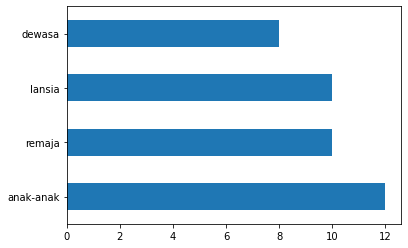

In [138]:
LPC_dataset['kelas_umur'].value_counts().plot(kind='barh')

## Analisis Data Eksploratif

In [139]:
LPC_dataset.describe().T

count        mean         std      min        25%       50%        75%  \
f1   40.0   689.11100  127.948459   482.29   585.3100   678.135   785.9675   
f2   40.0  1323.34225  229.659125   876.92  1216.5675  1350.750  1411.4975   
f3   40.0  2037.09825  289.953112  1559.76  1861.0250  1974.160  2146.7900   
f4   40.0  2830.60675  241.586379  2422.69  2691.8575  2782.490  2873.7425   
f5   40.0  3583.80250  280.142334  3183.82  3441.9125  3537.300  3651.8750   
f6   40.0  4387.06150  274.719921  4041.08  4227.0275  4296.395  4463.9275   
f7   40.0  5163.77275  295.102565  4815.37  5028.3450  5075.855  5150.4600   

        max  
f1  1014.87  
f2  2009.66  
f3  3141.28  
f4  3508.14  
f5  4552.25  
f6  5135.55  
f7  6000.00

*NB : Dari perbandingan nilai mean dan median didefenisikan ketujuh variabel frekuensi mendekati distribusi normal*

`Cek Normalisasi Data`

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

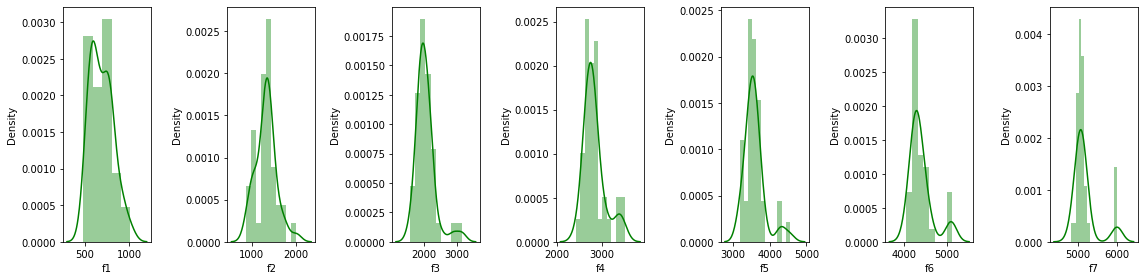

In [140]:
import seaborn as sns

plt.figure(figsize=(16,4))
for i in range(0,len(LPC_dataset[['f1','f2','f3','f4','f5','f6','f7']].columns)):
  plt.subplot(1,7,i+1)
  sns.distplot(LPC_dataset[LPC_dataset.columns[i]],color='green')
  plt.tight_layout()

`Cek Korelasi`

In [141]:
LPC_dataset.corr()

f1        f2        f3        f4        f5        f6        f7
f1  1.000000  0.315536  0.313499  0.441732  0.328326  0.393797  0.263920
f2  0.315536  1.000000  0.469001  0.483930  0.309745  0.398249  0.389158
f3  0.313499  0.469001  1.000000  0.760125  0.566436  0.627124  0.653882
f4  0.441732  0.483930  0.760125  1.000000  0.394011  0.588309  0.617650
f5  0.328326  0.309745  0.566436  0.394011  1.000000  0.693887  0.736501
f6  0.393797  0.398249  0.627124  0.588309  0.693887  1.000000  0.843777
f7  0.263920  0.389158  0.653882  0.617650  0.736501  0.843777  1.000000

<AxesSubplot:>

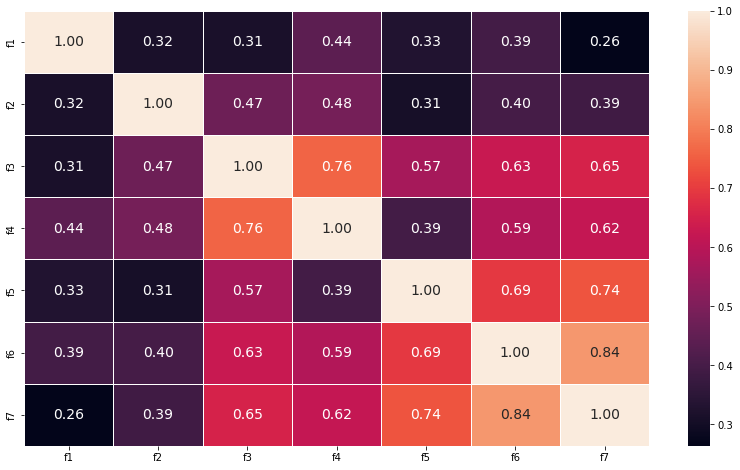

In [142]:
f,ax = plt.subplots(figsize=(14,8))
sns.heatmap(LPC_dataset.corr(), annot=True, annot_kws={"size": 14}, linewidths=.5, fmt= '.2f',ax=ax)

*drop variabel yang terkena multikolinearitas*

In [143]:
LPC_dataset.drop(['f3','f6','f7'],axis=1,inplace=True)

<AxesSubplot:>

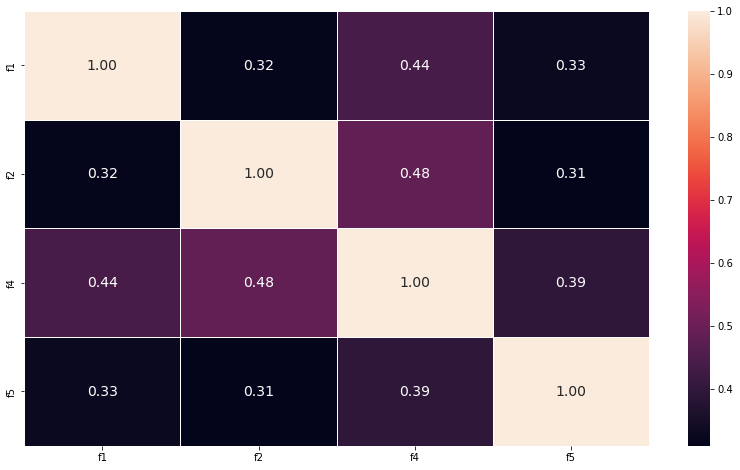

In [144]:
f,ax = plt.subplots(figsize=(14,8))
sns.heatmap(LPC_dataset.corr(), annot=True, annot_kws={"size": 14}, linewidths=.5, fmt= '.2f',ax=ax)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

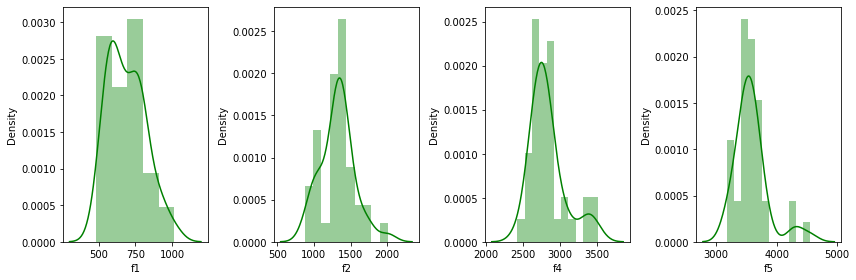

In [145]:
plt.figure(figsize=(12,4))
for i in range(0,len(LPC_dataset[['f1','f2','f4','f5']].columns)):
  plt.subplot(1,4,i+1)
  sns.distplot(LPC_dataset[LPC_dataset.columns[i]],color='green')
  plt.tight_layout()

*memisahkan variabel prediktor dan variabel target*

In [146]:
numerik_data = LPC_dataset.select_dtypes(include=[np.number])
kategorik_data = LPC_dataset.select_dtypes(exclude=[np.number])
print(numerik_data.shape)
print(kategorik_data.shape)

(40, 4)
(40, 1)


*membagi proporsi data train 70% dan data test 30%*

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    numerik_data, 
    kategorik_data, 
    test_size = 0.30,  #proporsi
    random_state = 20) #set acakan data

In [148]:
y_train.value_counts()

kelas_umur
anak-anak     8
lansia        7
remaja        7
dewasa        6
dtype: int64

In [149]:
y_test.value_counts()

kelas_umur
anak-anak     4
lansia        3
remaja        3
dewasa        2
dtype: int64

# Model k-Nearest Neighbor (KNN)

## Train Model

In [150]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV

*membuat data target menjadi bentuk label encoding*

In [151]:
lb = LabelEncoder()
lb.fit(y_train)

y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*melakukan standarisasi pada variabel prediktor*

In [152]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('bentuk data train = ', X_train.shape)
print('bentuk data test = ', X_test.shape)

bentuk data train =  (28, 4)
bentuk data test =  (12, 4)


`membangun model dengan membandingkan nilai k looping for (0 < k < 21`

In [153]:
test_skor = []
train_skor = []
accuracy = []

for i in range(1,21):

    knn = KNeighborsClassifier(i, metric='euclidean')
    knn.fit(X_train,y_train)
    
    y_pred = knn.predict(X_test)
    train_skor.append(knn.score(X_train,y_train))
    test_skor.append(knn.score(X_test,y_test))
    accuracy.append(accuracy_score(y_test, y_pred))

## Visualisasi Model

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Akurasi')

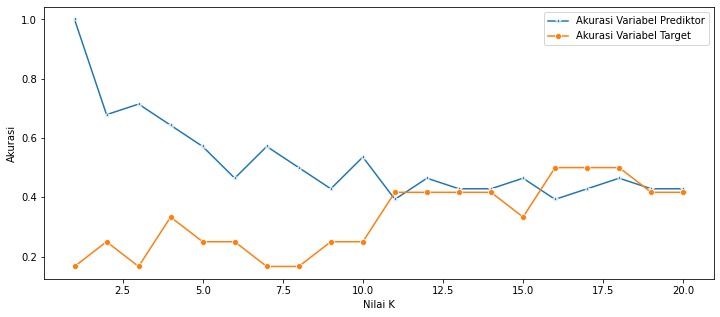

In [154]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,21),train_skor,marker='*',label='Akurasi Variabel Prediktor')
p = sns.lineplot(range(1,21),test_skor,marker='o',label='Akurasi Variabel Target')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi')

In [155]:
k = list(range(1,21))
df = pd.DataFrame(list(zip(k, train_skor, test_skor)),columns =['K', 'Train Skor', 'Test Skor'])

df.to_excel('akurasi_modeling.xlsx')

Text(0, 0.5, 'Rata-Rata Accuracy')

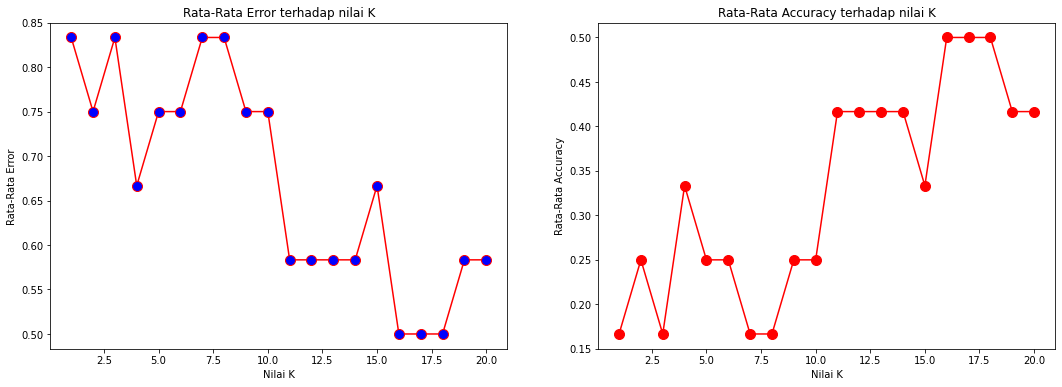

In [156]:
mean_error = []
mean_accuracy = []

for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
    knn.fit(X_train, y_train)

    pred_i = knn.predict(X_test)
    mean_error.append(np.mean(pred_i != y_test))
    mean_accuracy.append(1-np.mean(pred_i != y_test))

fig = plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot(range(1, 21), mean_error, color='red', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Rata-Rata Error terhadap nilai K')
plt.xlabel('Nilai K')
plt.ylabel('Rata-Rata Error')

plt.subplot(122)
plt.plot(range(1, 21), mean_accuracy, color='red', marker='o',markerfacecolor='red', markersize=10)
plt.title('Rata-Rata Accuracy terhadap nilai K')
plt.xlabel('Nilai K')
plt.ylabel('Rata-Rata Accuracy')

In [157]:
k = list(range(1,21))
df = pd.DataFrame(list(zip(k, mean_accuracy, mean_error)),columns =['K', 'Rata-Rata Accuracy', 'Rata-Rata Error'])
df = df.sort_values(['Rata-Rata Accuracy'],ascending=False)

df.to_excel('akurasi_modeling.xlsx')

## K Fold Cross Validation

In [158]:
def RandomSearchCV(x_train, y_train, classifier, param_range, folds):
  params = np.arange(1,21)
  params = np.array([int(i) for i in params])
  params = np.sort(params)
  kf = KFold(n_splits=folds)

  x_train = pd.DataFrame(x_train)
  y_train = pd.DataFrame(y_train)

  TRAIN_SCORES = []
  TEST_SCORES  = [] 
  for p in params:

    training_scores = []
    crossval_scores = []
    classifier.n_neighbors = int(p)

    for i in range(folds):
      result = next(kf.split(x_train),None)
      x_training = x_train.iloc[result[0]]
      x_cv = x_train.iloc[result[1]]

      y_training = y_train.iloc[result[0]]
      y_cv = y_train.iloc[result[1]]
      
      model = classifier.fit(x_training,y_training)
      training_scores.append(model.score(x_training,y_training))
      crossval_scores.append(model.score(x_cv,y_cv))

    TRAIN_SCORES.append(np.mean(training_scores))
    TEST_SCORES.append(np.mean(crossval_scores))
    
  return(TRAIN_SCORES , TEST_SCORES)

In [159]:
classifier = KNeighborsClassifier(metric='euclidean')
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
train_score , cv_scores = RandomSearchCV(X_train, y_train, classifier, (1,21), 5)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

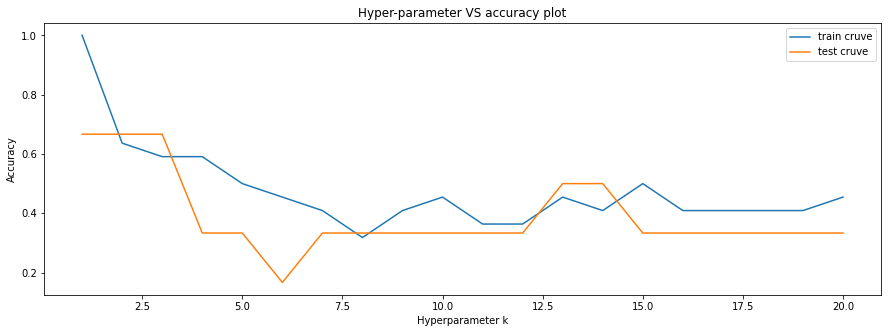

In [160]:
params = np.arange(1,21)
params = np.array([int(i) for i in params])
params = np.sort(params)

plt.figure(figsize=(15, 5))
plt.plot(params,train_score, label='train cruve')
plt.plot(params,cv_scores, label='test cruve')
plt.xlabel("Hyperparameter k")
plt.ylabel("Accuracy")
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

## Evaluasi Model

`Akurasi`

In [162]:
k = list(range(1,21))
df = pd.DataFrame(list(zip(k, train_score, cv_scores)),columns =['K', 'train accuracy', 'test accuracy'])
df.sort_values(['test accuracy'],ascending=False)

K  train accuracy  test accuracy
0    1        1.000000       0.666667
2    3        0.590909       0.666667
1    2        0.636364       0.666667
13  14        0.409091       0.500000
12  13        0.454545       0.500000
11  12        0.363636       0.333333
18  19        0.409091       0.333333
17  18        0.409091       0.333333
16  17        0.409091       0.333333
15  16        0.409091       0.333333
14  15        0.500000       0.333333
10  11        0.363636       0.333333
9   10        0.454545       0.333333
8    9        0.409091       0.333333
7    8        0.318182       0.333333
6    7        0.409091       0.333333
4    5        0.500000       0.333333
3    4        0.590909       0.333333
19  20        0.454545       0.333333
5    6        0.454545       0.166667

`Presisi dan Recall`

In [163]:
precisions = []
recalls = []

X = numerik_data
y = kategorik_data

knn = KNeighborsClassifier(n_neighbors=2, metric='euclidean')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit KNN classifier
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Kalkulasi Presisi dan Sensitivitas
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    precisions.append(precision)
    recalls.append(recall)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print("Mean precision: {:.2f}".format(mean_precision))
print("Mean recall: {:.2f}".format(mean_recall))

Mean precision: 0.24
Mean recall: 0.37


/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa